# Предсказание температуры стали

Для оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

Технологический процесс выглядит следующим образом:
1. Расплавленную сталь заливают в ковш и нагревают до нужной температуры графитовыми электродами.
2. Производят десульфурацию.
3. Производят замер температуры и химический анализ стали.
4. Повышают температуру на несколько минут и вводят легирующие добавки (сыпучие или проволочные материалы).
5. Продувают сплав инертным газом.
6. Перемешивают сплав, снова производят замер температуры и химический анализ стали.
7. При необходимости повторяют пп. 3...6 до достижения целевого химического состава и оптимальной температуры плавки.
8. Сталь поступает в машину непрерывной разливки, откуда выходит готовый продукт в виде заготовок-слябов.

Заказчик настаивает на том, что все полученные данные реальные и хотел бы получить модель, обученную на максимально полном объёме данных. При этом в данных могут быть нестыковки по времени выполнения операций - это особенности получения и записи информации с датчиков.

**План работы**

1. Исследовательский анализ данных.


2. Предобработка данных:
- агрегация данных по ключам и создание новых признаков;
- работа с пропусками;
- создание сводной таблицы.
3. Обучение моделей и выбор лучшей:
- простые модели;
- модель градиентного бустинга;
- константная модель для проверки адекватности.
4. Проверка качества модели на тестовой выборке.

## 1 Исследовательский анализ данных

Импортируем все необходимые для работы библиотеки, откроем файлы с данными и изучим общую информацию о них.

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# импорт структур и функций
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# импорт модуля time
import time

In [2]:
# установка максимального количества отображаемых столбцов
pd.options.display.max_columns = 50

# константа, фиксирующая случайность
rs = 250722

### 1.1 Данные об электродах

In [3]:
# чтение файла с данными об электродах
data_arc = pd.read_csv('D:/data_science/18_final_project/final_steel/data_arc.csv')
    
# просмотр первых пяти строк полученной таблицы
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
# получение общей информации о данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице 14876 записей, 5 признаков:
- `key` - номер партии;
- `начало нагрева дугой`;
- `конец нагрева дугой`;
- `активная мощность`;
- `реактивная мощность`.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам, кроме признаков начала и конца нагрева, которые следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [5]:
# переименование признаков
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'arc_heat_start',
                                    'Конец нагрева дугой':'arc_heat_end',
                                    'Активная мощность':'act_power',
                                    'Реактивная мощность':'react_power'}
                          )
# просмотр названий признаков
data_arc.columns

Index(['key', 'arc_heat_start', 'arc_heat_end', 'act_power', 'react_power'], dtype='object')

Признаки переименованы.

Заменим тип данных признаков `arc_heat_start` и `arc_heat_end` на `datetime64[ns]`:

In [6]:
data_arc[['arc_heat_start',
          'arc_heat_end']] = data_arc[['arc_heat_start',
                                       'arc_heat_end']].apply(pd.to_datetime)
data_arc.dtypes

key                        int64
arc_heat_start    datetime64[ns]
arc_heat_end      datetime64[ns]
act_power                float64
react_power              float64
dtype: object

Типы данных заменены.

In [7]:
# получение характерных значений количественных признаков
data_arc.describe()

,key,act_power,react_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В таблице присутствуют данные о ключах 1...3241. Посмотрим, сколько их всего:

In [8]:
data_arc['key'].nunique()

3214

Всего в данной таблице 3214 ключей, т.е. номера партий идут не по порядку, есть пропуски в нумерации.

Минимальное значение активной мощности - 0.03 у.е., среднее - 0.67 у.е., максимальное - 3.73 у.е. Явных ошибок пока не видно.

Минимальное значение реактивной мощности составляет -715 у.е., среднее - 0.45 у.е., максимальное - 2.68 у.е. Значение мощности не может быть отрицательным, следовательно, минимальная величина - это выброс, надо посмотреть, много ли отрицательных значений этого признака, и решить, что с ними делать.

In [9]:
# получение среза данных с реактивной мощностью меньше 0
data_arc.query('react_power < 0')

,key,arc_heat_start,arc_heat_end,act_power,react_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Только у одного ключа значение реактивной мощности отрицательное, удалим его из данных:

In [10]:
print(data_arc.shape)
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14876, 5)


(14872, 5)

Ключ с отрицательным значением реактивной мощности удалён.

Проверим, в каких временных диапазонах происходил нагрев дугой:

In [11]:
print('Минимальное время начала нагрева:', data_arc['arc_heat_start'].min())
print('Минимальное время конца нагрева:', data_arc['arc_heat_end'].min())
print('Максимальное время начала нагрева:', data_arc['arc_heat_start'].max())
print('Максимальное время конца нагрева:', data_arc['arc_heat_end'].max())

Минимальное время начала нагрева: 2019-05-03 11:02:14
Минимальное время конца нагрева: 2019-05-03 11:06:02
Максимальное время начала нагрева: 2019-09-01 04:34:47
Максимальное время конца нагрева: 2019-09-01 04:36:08


Данные о нагреве представлены за период с 11:02:14 3 мая по 04:36:08 1 сентября 2019 года.

### 1.2 Данные об объёме подачи сыпучих материалов

In [12]:
# чтение файла с данными об объёме подачи сыпучих материалов
data_bulk = pd.read_csv('D:/data_science/18_final_project/final_steel/data_bulk.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
# получение общей информации о данных
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - объёмы подачи сыпучих материалов 1...15.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [14]:
# переименование признаков
data_bulk = data_bulk.rename(columns={'Bulk 1':'bulk_1',
                                      'Bulk 2':'bulk_2',
                                      'Bulk 3':'bulk_3',
                                      'Bulk 4':'bulk_4',
                                      'Bulk 5':'bulk_5',
                                      'Bulk 6':'bulk_6',
                                      'Bulk 7':'bulk_7',
                                      'Bulk 8':'bulk_8',
                                      'Bulk 9':'bulk_9',
                                      'Bulk 10':'bulk_10',
                                      'Bulk 11':'bulk_11',
                                      'Bulk 12':'bulk_12',
                                      'Bulk 13':'bulk_13',
                                      'Bulk 14':'bulk_14',
                                      'Bulk 15':'bulk_15'}
                          )
# просмотр названий признаков
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Признаки переименованы.

In [15]:
# получение характерных значений количественных признаков
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице присутствуют данные о 3129 ключах, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах сыпучих материалов не выявлено.

### 1.3 Данные о времени подачи сыпучих материалов

In [16]:
# чтение файла с данными о времени подачи сыпучих материалов
data_bulk_time = pd.read_csv('D:/data_science/18_final_project/final_steel/data_bulk_time.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [17]:
# получение общей информации о данных
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - время подачи сыпучих материалов 1...15.

В данных о времени подачи сыпучих материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [18]:
data_bulk_time[['Bulk 1', 'Bulk 2',
                'Bulk 3', 'Bulk 4',
                'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8',
                'Bulk 9', 'Bulk 10',
                'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14',
                'Bulk 15']] = data_bulk_time[['Bulk 1', 'Bulk 2',
                                              'Bulk 3', 'Bulk 4',
                                              'Bulk 5', 'Bulk 6',
                                              'Bulk 7', 'Bulk 8',
                                              'Bulk 9', 'Bulk 10',
                                              'Bulk 11', 'Bulk 12',
                                              'Bulk 13', 'Bulk 14',
                                              'Bulk 15']].apply(pd.to_datetime)
data_bulk_time.dtypes

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [19]:
# просмотр минимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].min().min()

Timestamp('2019-05-03 11:03:52')

In [20]:
# просмотр максимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].max().max()

Timestamp('2019-09-01 04:05:34')

Данные о времени подачи сыпучих материалов представлены за период с 11:03:52 3 мая по 04:05:34 1 сентября 2019 года, что согласуется со временем нагрева.

### 1.4 Данные о продувке сплава газом

In [21]:
# чтение файла с данными о продувке сплава газом
data_gas = pd.read_csv('D:/data_science/18_final_project/final_steel/data_gas.csv')
    
# просмотр первых пяти строк полученной таблицы
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
# получение общей информации о данных
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице 3239 записей, 2 признака:
- `key` - номер партии;
- `Газ 1` - объём газа.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам.

Название признака следует дать латиницей в змеином регистре.

In [23]:
# переименование признаков
data_gas = data_gas.rename(columns={'Газ 1':'gas_1'})
# просмотр названий признаков
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

In [24]:
# получение характерных значений количественных признаков
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В таблице присутствуют данные о 3239 ключах, т.е. имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213). Проверим, что все ключи уникальные.

In [25]:
data_gas['key'].nunique()

3239

Количество уникальных ключей совпадает с количеством записей, ключи не повторяются. 

Минимальное значение объёма газа - 0.008 у.е., среднее - 11 у.е., максимальное - 78 у.е. Явных ошибок нет.

### 1.5 Результаты измерения температуры

In [26]:
# чтение файла с результатами измерения температуры
data_temp = pd.read_csv('D:/data_science/18_final_project/final_steel/data_temp.csv')
    
# просмотр первых пяти строк полученной таблицы
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
# получение общей информации о данных
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В таблице 15907 записей, 3 признака:
- `key` - номер партии;
- `время замера`;
- `температура`.

Присутствуют пропуски в температуре, проанализируем их позже. Типы данных соответствуют по смыслу признакам, кроме времени замера, который следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [28]:
# переименование признаков
data_temp = data_temp.rename(columns={'Время замера':'time_temp',
                                      'Температура':'temp'})
# просмотр названий признаков
data_temp.columns

Index(['key', 'time_temp', 'temp'], dtype='object')

Признаки переименованы.

Приведём время замера к типу даты и времени.

In [29]:
data_temp['time_temp'] = pd.to_datetime(data_temp['time_temp'], format='%Y-%m-%dT%H:%M:%S')
data_temp.dtypes

key                   int64
time_temp    datetime64[ns]
temp                float64
dtype: object

Тип данных заменён. Посмотрим, в каком временном диапазоне производились замеры температуры:

In [30]:
print('Минимальное время замера:', data_temp['time_temp'].min())
print('Максимальное время замера:', data_temp['time_temp'].max())

Минимальное время замера: 2019-05-03 11:16:18
Максимальное время замера: 2019-09-01 04:38:08


Данные о времени замера температуры представлены за период с 11:16:18 3 мая по 04:38:08 1 сентября 2019 года, что согласуется со временем нагрева.

In [31]:
# получение характерных значений количественных признаков
data_temp.describe()

,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


В таблице присутствуют данные о ключах 1...3241.

Минимальное значение температуры - 1191 градус, среднее - 1591 градус, максимальное - 1705 градус. Стандартное отклонение всего 21 градус, значит, минимальные и максимальные температуры довольно не типичны. Изучим распределение этого признака.

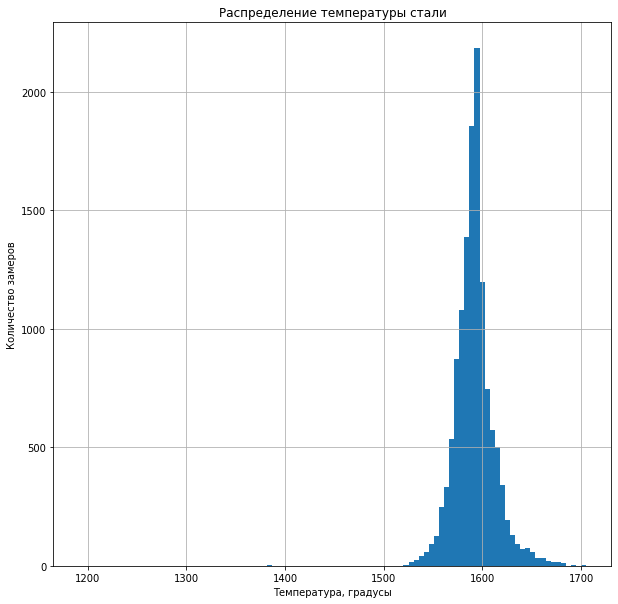

In [32]:
data_temp['temp'].hist(bins=100, figsize=(10,10))
plt.xlabel('Температура, градусы')
plt.ylabel('Количество замеров')
plt.title('Распределение температуры стали')
plt.show()

По гистограмме видно, что распределение температуры близко к нормальному и что практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. Посмотрим по диаграмме размаха на редкие значения.

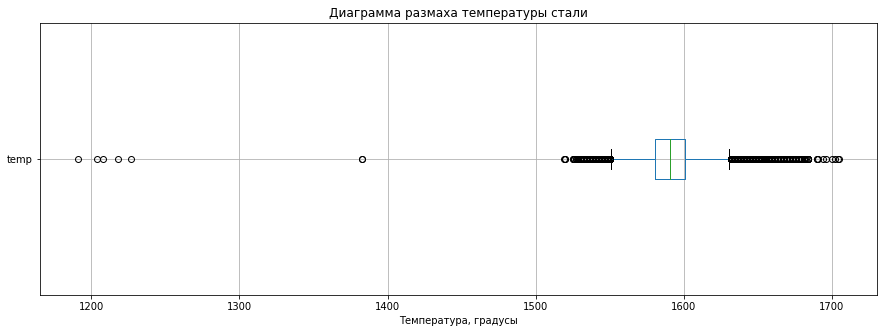

In [33]:
data_temp.boxplot(column='temp', figsize=(15, 5), vert=0)
plt.xlabel('Температура, градусы')
plt.title('Диаграмма размаха температуры стали')
plt.show()

На диаграмме размаха хорошо видно, что значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

Посмотрим на ключи записей, содержащих пропуски в температуре:

In [34]:
data_temp[data_temp['temp'].isna()].groupby('key')['key'].count()

key
2500    3
2501    4
2502    6
2503    3
2504    2
       ..
3237    4
3238    2
3239    7
3240    7
3241    4
Name: key, Length: 739, dtype: int64

Пропуски в температуре содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о партиях. Значит, эти ключи придётся исключить из дальнейшей работы.

### 1.6 Данные об объёме проволочных материалов

In [35]:
# чтение файла с данными об объёме проволочных материалов
data_wire = pd.read_csv('D:/data_science/18_final_project/final_steel/data_wire.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# получение общей информации о данных
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - объёмы подачи проволочных материалов 1...9.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [37]:
# переименование признаков
data_wire = data_wire.rename(columns={'Wire 1':'wire_1',
                                      'Wire 2':'wire_2',
                                      'Wire 3':'wire_3',
                                      'Wire 4':'wire_4',
                                      'Wire 5':'wire_5',
                                      'Wire 6':'wire_6',
                                      'Wire 7':'wire_7',
                                      'Wire 8':'wire_8',
                                      'Wire 9':'wire_9'}
                            )
# просмотр названий признаков
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Признаки переименованы.

In [38]:
# получение характерных значений количественных признаков
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В таблице присутствуют данные о 3081 ключе, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах проволочных материалов не выявлено.

### 1.7 Данные о времени подачи проволочных материалов

In [39]:
# чтение файла с данными о времени подачи проволочных материалов
data_wire_time = pd.read_csv('D:/data_science/18_final_project/final_steel/data_wire_time.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# получение общей информации о данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - время подачи проволочных материалов 1...9.

В данных о времени подачи проволочных материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [41]:
data_wire_time[['Wire 1', 'Wire 2',
                'Wire 3', 'Wire 4',
                'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8',
                'Wire 9']] = data_wire_time[['Wire 1', 'Wire 2',
                                             'Wire 3', 'Wire 4',
                                             'Wire 5', 'Wire 6',
                                             'Wire 7', 'Wire 8',
                                             'Wire 9']].apply(pd.to_datetime)
data_wire_time.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [42]:
# просмотр минимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].min().min()

Timestamp('2019-05-03 11:11:41')

In [43]:
# просмотр максимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].max().max()

Timestamp('2019-09-01 04:16:01')

Данные о времени подачи проволочных материалов представлены за период с 11:11:41 3 мая по 04:16:01 1 сентября 2019 года, что согласуется со временем нагрева и подачи сыпучих материалов.

### 1.8 Вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.

<b>Данные об электродах содержат информацию о:</b>
- номере партии,
- времени начала и конца прогрева дугой,
- активной и реактивной мощности.

В таблице 14876 записей, при этом партий (ключей) 3214: из-за того, что обработка партии происходит в несколько итераций, на каждый ключ приходится по несколько записей. Данные по ключам необходимо будет агрегировать. 

Пропусков и явных ошибок нет, кроме одного отрицательного значения реактивной мощности. Ключ, содержащий это значение, удалён.

<b>Данные об объёме подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного сыпучего материала 1...15.

В таблице 3129 записей, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- времени добавления сыпучего материала 1...15.

В таблице, также как и в предыдущей, 3129 записей, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому сыпучему материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

<b>Данные о продувке сплава газом содержат информацию о:</b>
- номере партии,
- объёме поданного газа.

В таблице 3239 записей, имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213).

Пропусков и явных ошибок нет.

<b>Результаты измерения температуры содержат информацию о:</b>
- номере партии,
- времени замера,
- температуре.

В таблице 15907 записей, на каждый ключ приходится по несколько записей. Для исследования представляют интерес начальная и конечная температура стали, являющаяся целевым признаком.

В данных имеются пропуски значений температуры. Они содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о химическом составе ключей, на основе которых можно было бы попытаться восстановить температуру. Значит, эти ключи придётся исключить из дальнейшей работы.

Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

<b>Данные об объёме проволочных материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного проволочного материала 1...9.

В таблице 3081 запись, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи проволочных материалов содержат информацию о:</b>
- номере партии,
- времени добавления проволочных материала 1...15.

В таблице, также как и в предыдущей, 3081 запись, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому проволочному материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

2. Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени.


3. В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.


4. В дальнейшем для работы все таблицы необходимо объединить в одну сводную по ключам так, чтобы каждая запись сводной таблицы содержала информацию об одном уникальном ключе. При этом в сводную таблицу войдут только те ключи, информация по которым содержится во всех 7 таблицах.

## 2 Предобработка данных

Для того, чтобы модель могла предсказывать температуру стали в партии, необходимо обработать имеющиеся данные:
- создать новые признаки, пригодные для обучения модели;
- заменить пропуски или удалить данные с ними;
- агрегировать данные по ключам, так как в данных об электродах, а также в результатах измерения температуры на каждый ключ приходится по несколько наблюдений из-за итеративности процесса;
- создать сводную таблицу со всеми признаками, отобранными для обучения.

Данные о времени подачи сыпучих и проволочных материалов для обучения модели не нужны.

Данные о продувке сплава газом не требуют предобработки. С остальными данными надо поработать.

### 2.1 Работа с данными об электродах

В данных об электродах содержится информация о времени начала и конца нагрева дугой. В таком виде признаки не пригодны для использования моделью. Посчитаем длительность нагрева в секундах и добавим в таблицу новый признак:

In [44]:
print(data_arc.shape)
data_arc['heat_duration'] = (data_arc['arc_heat_end'] - data_arc['arc_heat_start']).dt.seconds.astype('int64')
print(data_arc.shape)
data_arc.head(5)

(14872, 5)
(14872, 6)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


Длительность нагрева в секундах добавлена в таблицу.

Построим матрицу корреляции, чтобы проверить, как имеющиеся признаки коррелируют между собой.

In [45]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration
key,1.00,-0.02,-0.00,-0.02
act_power,-0.02,1.00,0.96,0.97
react_power,-0.00,0.96,1.00,0.97
heat_duration,-0.02,0.97,0.97,1.00


По матрице видно, что и активная, и реактивная мощности, и время нагрева сильно коррелируют. Значит, использовать все три признака вместе нельзя. Попробуем создать новые признаки и на основе корреляции выберем из них те, на которых будет обучаться модель.

Посчитаем соотношение активной и реактивной мощностей и добавим в таблицу новый признак:

In [46]:
print(data_arc.shape)
data_arc['power_ratio'] = data_arc['act_power'] / data_arc['react_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 6)
(14872, 7)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717


Соотношение посчитано, признак добавлен в таблицу.

Посчитаем общую мощность и добавим её в таблицу:

In [47]:
print(data_arc.shape)
data_arc['total_power'] = (data_arc['act_power']**2 + data_arc['react_power']**2)**0.5
print(data_arc.shape)
data_arc.head(5)

(14872, 7)
(14872, 8)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239


Общая мощнось посчитана и добавлена в таблицу.

Посчитаем работу и также добавим её в таблицу:

In [48]:
print(data_arc.shape)
data_arc['work'] = data_arc['heat_duration'] * data_arc['total_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 8)
(14872, 9)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239,119.471318


Работа посчитана и добавлена в таблицу.

Построим ещё раз матрицу корреляции с новыми признаками:

In [49]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration,power_ratio,total_power,work
key,1.00,-0.02,-0.00,-0.02,-0.09,-0.01,-0.01
act_power,-0.02,1.00,0.96,0.97,0.03,0.99,0.93
react_power,-0.00,0.96,1.00,0.97,-0.20,0.99,0.93
heat_duration,-0.02,0.97,0.97,1.00,-0.08,0.98,0.93
power_ratio,-0.09,0.03,-0.20,-0.08,1.00,-0.06,-0.05
total_power,-0.01,0.99,0.99,0.98,-0.06,1.00,0.94
work,-0.01,0.93,0.93,0.93,-0.05,0.94,1.00


По матрице видно, что из всех признаков корреляция отсутствует у продолжительности нагрева и отношения активной и реактивной мощностей. Значит, для обучения модели оставим только эти признаки.

Выведем для сравнения характерные значения признака `power_ratio` перед созданием сводной таблицы.

In [50]:
data_arc['power_ratio'].describe()

count    14872.000000
mean         1.360652
std          0.173105
min          0.457980
25%          1.257090
50%          1.376057
75%          1.480514
max          1.949831
Name: power_ratio, dtype: float64

Создадим сводную таблицу с группировкой по ключам, суммарной мощностью и медианным соотношением активной и реактивной мощностей для каждого ключа:

In [51]:
arc_pivot = data_arc.pivot_table(index='key',
                                 values=('heat_duration', 'power_ratio'),
                                 aggfunc={'heat_duration':'sum',
                                          'power_ratio':'median'}).reset_index()
arc_pivot.columns = ['key', 'heat_dur_sum', 'power_ratio_median']
arc_pivot.head()

,key,heat_dur_sum,power_ratio_median
0,1,1098,1.548395
1,2,811,1.574566
2,3,655,1.581626
3,4,741,1.601656
4,5,869,1.499092


Создана таблица с наблюдениями, соответствующими уникальным ключам. Для каждого ключа посчитано суммарное время нагрева и медианное отношение активной и реактивной мощностей.

Посмотрим на характерные значения признака `power_ratio` после создания сводной таблицы:

In [52]:
arc_pivot['power_ratio_median'].describe()

count    3213.000000
mean        1.371198
std         0.145075
min         0.591452
25%         1.298891
50%         1.384662
75%         1.461785
max         1.894052
Name: power_ratio_median, dtype: float64

Характерные значения отношения мощностей изменились не сильно, признак можно использовать в работе.
- Диапазон значений и стандартное отклонение несколько уменьшились: было 0,46...1,95 и 0,17, стало 0,59...1,89 и 0,14;
- среднее и медиана изменились на 0,01: с 1,36 на 1,37 и с 1,37 на 1,38.

### 2.2 Работа с результатами измерения температуры

Ранее мы видели, что в ключах, начиная с 2500, есть пропуски в значениях температуры. Если пропуски в первой или последней температурах по времени, это не позволит использовать данные по таким ключам. Заменим пропуски на нули, чтобы корректно отобрать начальную и конечную температуры. После группировки удалим ключи с нулевыми температурами.

In [53]:
print(data_temp.isna().sum())
data_temp = data_temp.fillna(0)
data_temp.isna().sum()

key             0
time_temp       0
temp         2901
dtype: int64


key          0
time_temp    0
temp         0
dtype: int64

Пропуски заменены на нули. Теперь сгруппируем данные по ключам и создадим новые признаки для каждого из них: начальную и конечную температуры стали.

In [54]:
temp_pivot = data_temp.pivot_table(index='key',
                                   values='temp',
                                   aggfunc=('first', 'last')).reset_index()
temp_pivot.columns = ['key', 'first_temp', 'last_temp']
temp_pivot.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Мы получили сводную таблицу с данными о начальной и конечной температуре стали каждого ключа. Посмотрим на характерные значения полученных признаков.

In [55]:
temp_pivot.describe()

,key,first_temp,last_temp
count,3216.000000,3216.000000,3216.000000
mean,1622.199316,1588.592040,1228.744714
std,935.088523,29.137454,671.403549
min,1.000000,1191.000000,0.000000
25%,815.750000,1572.000000,1574.000000
50%,1622.500000,1588.000000,1590.000000
75%,2431.250000,1606.000000,1597.000000
max,3241.000000,1684.000000,1700.000000


Часть пропусков оказалась в конечной температуре: минимальное значение признака равно нулю. Удалим ключи с нулевой конечной температурой:

In [56]:
print(temp_pivot.shape)
temp_pivot = temp_pivot[temp_pivot.last_temp != 0]
temp_pivot.shape

(3216, 3)


(2477, 3)

Ключи с нулевой конечной температурой удалены.

По уточнённым данным от заказчика, ключи с начальной температурой ниже 1500 градусов также следует удалить, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель. Удаляем:

In [57]:
temp_pivot = temp_pivot[temp_pivot.first_temp >= 1500]
temp_pivot.shape

(2473, 3)

Ключи с начальной температурой ниже 1500 градусов удалены.

### 2.3 Работа с данными об объёме подачи сыпучих и проволочных материалов

В данных много пропусков, т.к. в разные ключи добавляют разные сыпучие и проволочные материалы. Пропуски показывают, что данный сыпучий или проволочный материал в ключ не добавляли. Значит, их можно заменить на нули.

Также среди сыпучих материалов есть материал `bulk_8`, а среди проволочных - `wire_5`, которые были добавлен только по одному разу. Такие признаки будут неинформатвны, лучше их удалить.

In [58]:
# удаление сыпучего материала bulk_8
print(data_bulk.shape)
data_bulk = data_bulk.drop(columns=['bulk_8'])
data_bulk.shape

(3129, 16)


(3129, 15)

In [59]:
# удаление проволочного материала wire_5
print(data_wire.shape)
data_wire = data_wire.drop(columns=['wire_5'])
data_wire.shape

(3081, 10)


(3081, 9)

Признаки удалены. Теперь заменим все пропуски на нули.

In [60]:
# замена пропусков на нули в данных о сыпучих материалах
print(data_bulk.isna().sum())
data_bulk = data_bulk.fillna(0)
data_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [61]:
# замена пропусков на нули в данных о проволочных материалах
print(data_wire.isna().sum())
data_wire = data_wire.fillna(0)
data_wire.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропуски заменены на нули.

### 2.4 Создание сводной таблицы

Объединим в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.

Объединять будем так, чтобы в сводную таблицу попали только те ключи, данные о которых есть во всех объединяемых таблицах.

In [62]:
df = arc_pivot.merge(temp_pivot, on='key')
df = df.merge(data_gas, on='key')
df = df.merge(data_bulk, on='key')
df = df.merge(data_wire, on='key')
display(df.head(10))
df.shape

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1098,1.548395,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,1.574566,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,1.581626,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,1.601656,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,1.499092,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,6,952,1.530188,1543.0,1596.0,11.273392,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
6,7,673,1.632877,1586.0,1599.0,9.836267,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,8,913,1.559012,1577.0,1598.0,15.171553,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,9,625,1.457549,1587.0,1592.0,8.216623,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0
9,10,825,1.244260,1574.0,1593.0,6.529891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0


(2324, 28)

Мы получили сводную таблицу, каждое из 2324 наблюдений которой содержит информацию об уникальном ключе.

В таблице 28 признаков, один из которых - конечная температура - является целевым.

Ещё один признак - номер партии - для обучения не нужен, удалим его позже.

Посмотрим на корреляцию полученных признаков.

In [63]:
corr_df = df.corr()
corr_df.style.background_gradient(cmap='Greens').set_precision(2)

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,1.00,-0.03,-0.13,-0.02,-0.10,-0.04,-0.08,-0.01,-0.01,-0.03,0.04,0.01,0.05,-0.04,0.06,0.04,0.03,-0.02,-0.11,-0.04,-0.01,0.04,-0.03,0.05,-0.01,0.04,-0.04,0.02
heat_dur_sum,-0.03,1.00,0.10,-0.38,0.28,0.40,0.10,0.04,0.09,-0.03,0.01,0.16,0.08,0.01,-0.01,0.08,0.47,0.13,0.46,0.29,0.06,0.05,0.03,0.05,0.04,0.03,0.02,-0.01
power_ratio_median,-0.13,0.10,1.00,-0.10,0.18,0.09,-0.10,-0.05,0.15,0.02,-0.03,0.02,-0.04,0.05,0.02,-0.02,0.10,-0.00,0.15,0.14,0.13,0.00,0.02,-0.03,-0.01,-0.04,0.05,-0.00
first_temp,-0.02,-0.38,-0.10,1.00,0.30,0.04,0.08,0.14,-0.11,0.17,0.08,-0.13,0.09,-0.03,0.04,-0.11,-0.08,0.02,-0.18,-0.06,0.26,-0.10,-0.00,0.08,0.02,0.05,-0.03,0.00
last_temp,-0.10,0.28,0.18,0.30,1.00,0.06,-0.08,-0.08,-0.04,0.19,-0.03,-0.18,-0.11,-0.02,0.06,-0.11,0.27,-0.01,0.11,0.27,0.32,-0.21,-0.05,-0.16,-0.08,-0.14,-0.01,-0.03
gas_1,-0.04,0.40,0.09,0.04,0.06,1.00,0.23,0.22,0.06,0.02,0.09,0.14,0.20,0.12,-0.01,0.04,0.22,0.05,0.27,0.04,0.12,0.10,0.10,0.15,0.11,0.08,0.12,0.01
bulk_1,-0.08,0.10,-0.10,0.08,-0.08,0.23,1.00,0.22,-0.01,0.04,0.06,-0.00,0.24,-0.02,-0.02,-0.04,0.33,-0.01,0.21,-0.00,0.01,-0.01,0.02,0.15,0.15,0.08,-0.02,0.01
bulk_2,-0.01,0.04,-0.05,0.14,-0.08,0.22,0.22,1.00,-0.05,0.04,0.36,-0.03,0.68,-0.01,-0.02,0.00,-0.10,-0.01,-0.14,-0.11,-0.17,-0.04,0.22,0.70,0.56,0.43,-0.01,-0.01
bulk_3,-0.01,0.09,0.15,-0.11,-0.04,0.06,-0.01,-0.05,1.00,-0.30,-0.01,0.07,-0.03,0.01,-0.09,-0.01,0.02,-0.01,0.01,-0.01,0.04,0.09,0.01,-0.04,0.01,-0.02,0.00,0.00
bulk_4,-0.03,-0.03,0.02,0.17,0.19,0.02,0.04,0.04,-0.30,1.00,0.03,-0.25,0.05,-0.00,-0.08,-0.12,0.11,0.00,-0.09,0.10,0.30,-0.27,-0.04,0.03,-0.01,0.03,0.01,-0.06


Мы получили несколько признаков с сильной корреляцией:
- `bulk_9` и `wire_8`: 0,97;
- `bulk_7` и `wire_4`: 0,74;
- `bulk_2` и `wire_4`: 0,7.

У всех этих признаков много нулевых значений. Удалим из каждой пары по одному признаку, а заодно, и номер партии.

In [64]:
df = df.drop(['key', 'bulk_9', 'wire_4'], axis=1)
df.shape

(2324, 25)

Признаки удалены.

### 2.5 Вывод

Произведена предобработка данных.

1. Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
2. Для каждого ключа определены начальная и конечная температуры.
3. Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
4. Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
5. Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
6. Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
7. Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.

## 3 Обучение и выбор лучшей модели

Подберём лучшие гиперпараметры и обучим линейную регрессиию, дерево решений, случайный лес, модель градиентного бустинга. Для проверки адекватности моделей обучим также константную модель.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8. 

### 3.1 Подготовка к обучению

Разделим данные на обучающую и тестовую выборки в соотношении 75:25.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['last_temp'], axis=1),
    df['last_temp'], test_size=0.25)

print(f'Размер признаков обучающей выборки: {X_train.shape}')
print(f'Размер целевого признака обучающей выборки: {y_train.shape}')
print(f'Размер признаков тестовой выборки: {X_test.shape}')
print(f'Размер целевого признака тестовой выборки: {y_test.shape}')

Размер признаков обучающей выборки: (1743, 24)
Размер целевого признака обучающей выборки: (1743,)
Размер признаков тестовой выборки: (581, 24)
Размер целевого признака тестовой выборки: (581,)


Данные разделены корректно.

Для обучения моделей и подбора гиперпараметров напишем собственную функцию с использованием <i>Pipeline</i> и <i>GridSearch</i>.

In [66]:
# создание функции для подбора параметров лучшей модели
def pipeline(model, X, y, params):
  '''
  функция для подбора лучших гиперпараметров и обучения модели:
  на вход принимает модель с параметрами, признаки и целевой признак,
  возвращает значение MAE на обучающей выборке, лучшую модель и
  выводит на экран значение MAE и подобранные гиперпараметры
  '''
  pipe = Pipeline([('model', model)])
  param = params

  grid = GridSearchCV(pipe, param,
                      scoring='neg_mean_absolute_error',
                      cv=5)
  
  grid.fit(X, y)

  print('Лучшее значение MAE:', grid.best_score_)
  print('Лучшие параметры', grid.best_params_)
  
  return grid.best_score_, grid

### 3.2 Линейная регрессия

Обучим линейную регрессию с использованием <i>pipeline</i> и кросс-валидации. Внутри <i>pipeline</i> произведём масштабирование признаков, чтобы алгоритм не выделял на основе порядка и разброса одни признаки как более важные, другие - как менее важные.

In [67]:
# создание объекта pipeline
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('linreg', LinearRegression())
])
# получение оценок кросс-валидацией
scores = cross_val_score(pipe_lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)
print('MAE =', abs(scores.mean()))

MAE = 6.26814270362568


Получили неплохое значение метрики. Посмотрим, как справятся с задачей остальные модели.

### 3.3 Дерево решений

In [68]:
%%time
# инициализация модели дерева решений 
model_dt = DecisionTreeRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_dt = {'model__max_depth': range(2, 15),
            'model__min_samples_leaf': [2, 5]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dt, best_model_dt = pipeline(model_dt, X_train, y_train, param_dt)

Лучшее значение MAE: -7.339578841941181
Лучшие параметры {'model__max_depth': 5, 'model__min_samples_leaf': 2}
Wall time: 2.21 s


Значение метрики хуже, чем у линейной регрессии.

### 3.4 Случайный лес

In [69]:
%%time
# инициализация модели случайного леса
model_rf = RandomForestRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_rf = {'model__n_estimators': range(10, 15),
            'model__max_depth': range(2, 11)}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_rf, best_model_rf = pipeline(model_rf, X_train, y_train, param_rf)

Лучшее значение MAE: -6.428707693803221
Лучшие параметры {'model__max_depth': 10, 'model__n_estimators': 14}
Wall time: 17.6 s


Значение метрики хуже, чем у линейной регрессии, но лучше, чем у дерева решений.

### 3.5 <i>CatBoostRegressor</i>

In [70]:
%%time
# инициализация модели CatBoostRegressor
model_cbr = CatBoostRegressor(iterations=150, random_state=rs)

# установка диапазонов гиперпараметров
param_cbr = {'model__depth': range(2, 7),
             'model__learning_rate': [0.05, 0.1, 0.15]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_cbr, best_model_cbr = pipeline(model_cbr, X_train, y_train, param_cbr)

0:	learn: 11.2661932	total: 45.9ms	remaining: 6.84s
1:	learn: 11.2036605	total: 47.2ms	remaining: 3.49s
2:	learn: 11.1515933	total: 48.5ms	remaining: 2.37s
3:	learn: 11.1014832	total: 49.9ms	remaining: 1.82s
4:	learn: 11.0211782	total: 50.6ms	remaining: 1.47s
5:	learn: 10.9568941	total: 51.7ms	remaining: 1.24s
6:	learn: 10.9177373	total: 53.2ms	remaining: 1.09s
7:	learn: 10.8780379	total: 54.2ms	remaining: 961ms
8:	learn: 10.8428817	total: 55.3ms	remaining: 867ms
9:	learn: 10.7965810	total: 56.5ms	remaining: 790ms
10:	learn: 10.7492582	total: 57.8ms	remaining: 730ms
11:	learn: 10.7036875	total: 58.5ms	remaining: 673ms
12:	learn: 10.6568998	total: 59.4ms	remaining: 626ms
13:	learn: 10.6227072	total: 60.5ms	remaining: 588ms
14:	learn: 10.5774031	total: 61.9ms	remaining: 557ms
15:	learn: 10.5348352	total: 62.9ms	remaining: 526ms
16:	learn: 10.5037181	total: 64ms	remaining: 501ms
17:	learn: 10.4732301	total: 66.1ms	remaining: 485ms
18:	learn: 10.4422135	total: 67.2ms	remaining: 464ms
19:	l

64:	learn: 8.9536172	total: 74.4ms	remaining: 97.2ms
65:	learn: 8.9339471	total: 75.4ms	remaining: 95.9ms
66:	learn: 8.9070159	total: 76.7ms	remaining: 95ms
67:	learn: 8.8923566	total: 78.3ms	remaining: 94.4ms
68:	learn: 8.8752584	total: 79.3ms	remaining: 93.1ms
69:	learn: 8.8579441	total: 80.3ms	remaining: 91.7ms
70:	learn: 8.8480039	total: 81.4ms	remaining: 90.6ms
71:	learn: 8.8374522	total: 82.9ms	remaining: 89.9ms
72:	learn: 8.8258708	total: 84.2ms	remaining: 88.8ms
73:	learn: 8.8100759	total: 85.4ms	remaining: 87.7ms
74:	learn: 8.7975449	total: 86.7ms	remaining: 86.7ms
75:	learn: 8.7737543	total: 87.9ms	remaining: 85.5ms
76:	learn: 8.7583369	total: 90.4ms	remaining: 85.7ms
77:	learn: 8.7462766	total: 91.7ms	remaining: 84.6ms
78:	learn: 8.7373263	total: 92.8ms	remaining: 83.4ms
79:	learn: 8.7222893	total: 94.6ms	remaining: 82.8ms
80:	learn: 8.7077736	total: 99ms	remaining: 84.3ms
81:	learn: 8.6949944	total: 100ms	remaining: 83.1ms
82:	learn: 8.6826754	total: 101ms	remaining: 81.8ms

76:	learn: 8.8237632	total: 83.8ms	remaining: 79.4ms
77:	learn: 8.8091434	total: 85ms	remaining: 78.5ms
78:	learn: 8.7998849	total: 86.5ms	remaining: 77.7ms
79:	learn: 8.7868480	total: 87.5ms	remaining: 76.6ms
80:	learn: 8.7753939	total: 88.6ms	remaining: 75.4ms
81:	learn: 8.7587633	total: 89.6ms	remaining: 74.3ms
82:	learn: 8.7494901	total: 90.6ms	remaining: 73.1ms
83:	learn: 8.7378437	total: 91.6ms	remaining: 72ms
84:	learn: 8.7306181	total: 92.6ms	remaining: 70.8ms
85:	learn: 8.7225520	total: 94.3ms	remaining: 70.2ms
86:	learn: 8.7079011	total: 97.8ms	remaining: 70.8ms
87:	learn: 8.6976044	total: 99.5ms	remaining: 70.1ms
88:	learn: 8.6937983	total: 101ms	remaining: 69.3ms
89:	learn: 8.6836692	total: 102ms	remaining: 68.3ms
90:	learn: 8.6665840	total: 103ms	remaining: 67ms
91:	learn: 8.6550179	total: 104ms	remaining: 65.8ms
92:	learn: 8.6466770	total: 105ms	remaining: 64.6ms
93:	learn: 8.6272215	total: 106ms	remaining: 63.3ms
94:	learn: 8.6087861	total: 107ms	remaining: 62.1ms
95:	le

103:	learn: 8.4770004	total: 105ms	remaining: 46.3ms
104:	learn: 8.4697128	total: 106ms	remaining: 45.4ms
105:	learn: 8.4604213	total: 107ms	remaining: 44.4ms
106:	learn: 8.4510572	total: 108ms	remaining: 43.5ms
107:	learn: 8.4440384	total: 109ms	remaining: 42.5ms
108:	learn: 8.4372048	total: 110ms	remaining: 41.5ms
109:	learn: 8.4268254	total: 111ms	remaining: 40.5ms
110:	learn: 8.4197774	total: 113ms	remaining: 39.7ms
111:	learn: 8.4103258	total: 114ms	remaining: 38.7ms
112:	learn: 8.4022761	total: 115ms	remaining: 37.6ms
113:	learn: 8.3909488	total: 116ms	remaining: 36.7ms
114:	learn: 8.3849649	total: 118ms	remaining: 35.9ms
115:	learn: 8.3721834	total: 120ms	remaining: 35.1ms
116:	learn: 8.3617291	total: 121ms	remaining: 34.2ms
117:	learn: 8.3490092	total: 123ms	remaining: 33.3ms
118:	learn: 8.3406577	total: 125ms	remaining: 32.4ms
119:	learn: 8.3313585	total: 126ms	remaining: 31.4ms
120:	learn: 8.3219872	total: 127ms	remaining: 30.4ms
121:	learn: 8.3136899	total: 128ms	remaining: 

129:	learn: 8.5478227	total: 143ms	remaining: 22ms
130:	learn: 8.5395939	total: 145ms	remaining: 21ms
131:	learn: 8.5348336	total: 146ms	remaining: 19.9ms
132:	learn: 8.5259251	total: 147ms	remaining: 18.8ms
133:	learn: 8.5182280	total: 148ms	remaining: 17.7ms
134:	learn: 8.5072490	total: 150ms	remaining: 16.6ms
135:	learn: 8.4969391	total: 151ms	remaining: 15.5ms
136:	learn: 8.4921030	total: 152ms	remaining: 14.4ms
137:	learn: 8.4858365	total: 153ms	remaining: 13.3ms
138:	learn: 8.4767647	total: 154ms	remaining: 12.2ms
139:	learn: 8.4701500	total: 155ms	remaining: 11ms
140:	learn: 8.4634480	total: 156ms	remaining: 9.93ms
141:	learn: 8.4597110	total: 157ms	remaining: 8.83ms
142:	learn: 8.4522134	total: 159ms	remaining: 7.78ms
143:	learn: 8.4464793	total: 160ms	remaining: 6.66ms
144:	learn: 8.4418184	total: 161ms	remaining: 5.56ms
145:	learn: 8.4340792	total: 162ms	remaining: 4.44ms
146:	learn: 8.4309354	total: 163ms	remaining: 3.33ms
147:	learn: 8.4231959	total: 164ms	remaining: 2.22ms

138:	learn: 7.7209694	total: 167ms	remaining: 13.2ms
139:	learn: 7.7172794	total: 170ms	remaining: 12.1ms
140:	learn: 7.7114295	total: 172ms	remaining: 11ms
141:	learn: 7.7053691	total: 178ms	remaining: 10ms
142:	learn: 7.6980884	total: 180ms	remaining: 8.83ms
143:	learn: 7.6903293	total: 183ms	remaining: 7.61ms
144:	learn: 7.6842503	total: 185ms	remaining: 6.37ms
145:	learn: 7.6811328	total: 187ms	remaining: 5.13ms
146:	learn: 7.6741786	total: 189ms	remaining: 3.86ms
147:	learn: 7.6632791	total: 191ms	remaining: 2.58ms
148:	learn: 7.6550614	total: 194ms	remaining: 1.3ms
149:	learn: 7.6474582	total: 196ms	remaining: 0us
0:	learn: 10.9608380	total: 1.36ms	remaining: 202ms
1:	learn: 10.8469180	total: 3.06ms	remaining: 227ms
2:	learn: 10.7563095	total: 5.15ms	remaining: 252ms
3:	learn: 10.6256199	total: 6.51ms	remaining: 238ms
4:	learn: 10.5284519	total: 7.71ms	remaining: 224ms
5:	learn: 10.4077615	total: 8.8ms	remaining: 211ms
6:	learn: 10.3317175	total: 9.84ms	remaining: 201ms
7:	learn:

1:	learn: 10.8815576	total: 3.29ms	remaining: 243ms
2:	learn: 10.7757727	total: 4.9ms	remaining: 240ms
3:	learn: 10.6240862	total: 6.64ms	remaining: 243ms
4:	learn: 10.5001108	total: 7.83ms	remaining: 227ms
5:	learn: 10.3956229	total: 9.08ms	remaining: 218ms
6:	learn: 10.3152749	total: 10.8ms	remaining: 220ms
7:	learn: 10.2615423	total: 12.4ms	remaining: 221ms
8:	learn: 10.2051073	total: 13.8ms	remaining: 216ms
9:	learn: 10.1390686	total: 15.4ms	remaining: 216ms
10:	learn: 10.0624164	total: 16.9ms	remaining: 214ms
11:	learn: 10.0080283	total: 18.2ms	remaining: 209ms
12:	learn: 9.9504206	total: 20.4ms	remaining: 215ms
13:	learn: 9.8820772	total: 21.4ms	remaining: 208ms
14:	learn: 9.8388210	total: 23.3ms	remaining: 210ms
15:	learn: 9.7649530	total: 24.6ms	remaining: 206ms
16:	learn: 9.7047212	total: 26.1ms	remaining: 204ms
17:	learn: 9.6138551	total: 27.7ms	remaining: 203ms
18:	learn: 9.5760529	total: 29.2ms	remaining: 201ms
19:	learn: 9.5352367	total: 31ms	remaining: 202ms
20:	learn: 9.

40:	learn: 8.6818741	total: 55ms	remaining: 146ms
41:	learn: 8.6768229	total: 56.2ms	remaining: 145ms
42:	learn: 8.6376713	total: 57.6ms	remaining: 143ms
43:	learn: 8.6077007	total: 58.8ms	remaining: 142ms
44:	learn: 8.5849949	total: 60.7ms	remaining: 142ms
45:	learn: 8.5604302	total: 62.4ms	remaining: 141ms
46:	learn: 8.5519785	total: 63.5ms	remaining: 139ms
47:	learn: 8.5270514	total: 64.9ms	remaining: 138ms
48:	learn: 8.5119337	total: 66.2ms	remaining: 136ms
49:	learn: 8.4962371	total: 68.4ms	remaining: 137ms
50:	learn: 8.4777512	total: 70ms	remaining: 136ms
51:	learn: 8.4663959	total: 71.1ms	remaining: 134ms
52:	learn: 8.4468165	total: 73.1ms	remaining: 134ms
53:	learn: 8.4308778	total: 74.5ms	remaining: 132ms
54:	learn: 8.4026387	total: 76.1ms	remaining: 131ms
55:	learn: 8.3943019	total: 78.2ms	remaining: 131ms
56:	learn: 8.3730018	total: 79.3ms	remaining: 129ms
57:	learn: 8.3564324	total: 80.4ms	remaining: 127ms
58:	learn: 8.3409606	total: 81.9ms	remaining: 126ms
59:	learn: 8.321

83:	learn: 8.2589587	total: 112ms	remaining: 88.2ms
84:	learn: 8.2531208	total: 113ms	remaining: 86.7ms
85:	learn: 8.2419401	total: 115ms	remaining: 85.4ms
86:	learn: 8.2231426	total: 116ms	remaining: 84.1ms
87:	learn: 8.2148611	total: 117ms	remaining: 82.7ms
88:	learn: 8.2022395	total: 119ms	remaining: 81.7ms
89:	learn: 8.1877554	total: 121ms	remaining: 80.5ms
90:	learn: 8.1708974	total: 123ms	remaining: 79.5ms
91:	learn: 8.1606912	total: 125ms	remaining: 78.5ms
92:	learn: 8.1483077	total: 126ms	remaining: 77.4ms
93:	learn: 8.1332718	total: 127ms	remaining: 75.9ms
94:	learn: 8.1226249	total: 129ms	remaining: 74.4ms
95:	learn: 8.1167545	total: 131ms	remaining: 73.6ms
96:	learn: 8.1092857	total: 132ms	remaining: 72.1ms
97:	learn: 8.0985942	total: 134ms	remaining: 70.9ms
98:	learn: 8.0906589	total: 135ms	remaining: 69.4ms
99:	learn: 8.0850539	total: 136ms	remaining: 68ms
100:	learn: 8.0772504	total: 138ms	remaining: 66.9ms
101:	learn: 8.0641063	total: 139ms	remaining: 65.4ms
102:	learn: 

94:	learn: 7.7143197	total: 119ms	remaining: 69.1ms
95:	learn: 7.7036043	total: 121ms	remaining: 68.2ms
96:	learn: 7.6889685	total: 123ms	remaining: 67ms
97:	learn: 7.6801469	total: 124ms	remaining: 65.7ms
98:	learn: 7.6720950	total: 125ms	remaining: 64.5ms
99:	learn: 7.6677365	total: 127ms	remaining: 63.4ms
100:	learn: 7.6578042	total: 133ms	remaining: 64.6ms
101:	learn: 7.6391031	total: 135ms	remaining: 63.6ms
102:	learn: 7.6342887	total: 136ms	remaining: 62.2ms
103:	learn: 7.6228366	total: 138ms	remaining: 60.9ms
104:	learn: 7.6148482	total: 139ms	remaining: 59.6ms
105:	learn: 7.6053092	total: 141ms	remaining: 58.4ms
106:	learn: 7.5958858	total: 142ms	remaining: 57.2ms
107:	learn: 7.5851522	total: 144ms	remaining: 55.9ms
108:	learn: 7.5769927	total: 145ms	remaining: 54.6ms
109:	learn: 7.5650542	total: 146ms	remaining: 53.2ms
110:	learn: 7.5611547	total: 148ms	remaining: 52ms
111:	learn: 7.5545600	total: 149ms	remaining: 50.5ms
112:	learn: 7.5450700	total: 150ms	remaining: 49.1ms
113

136:	learn: 7.1461446	total: 175ms	remaining: 16.6ms
137:	learn: 7.1445416	total: 176ms	remaining: 15.3ms
138:	learn: 7.1419172	total: 178ms	remaining: 14.1ms
139:	learn: 7.1359612	total: 180ms	remaining: 12.8ms
140:	learn: 7.1334950	total: 181ms	remaining: 11.6ms
141:	learn: 7.1242219	total: 182ms	remaining: 10.3ms
142:	learn: 7.1204214	total: 184ms	remaining: 9.02ms
143:	learn: 7.1185951	total: 186ms	remaining: 7.75ms
144:	learn: 7.1159629	total: 187ms	remaining: 6.45ms
145:	learn: 7.1126085	total: 189ms	remaining: 5.17ms
146:	learn: 7.1015525	total: 190ms	remaining: 3.88ms
147:	learn: 7.0971076	total: 191ms	remaining: 2.58ms
148:	learn: 7.0959916	total: 193ms	remaining: 1.29ms
149:	learn: 7.0913200	total: 194ms	remaining: 0us
0:	learn: 10.9678380	total: 1.2ms	remaining: 179ms
1:	learn: 10.7646288	total: 2.24ms	remaining: 166ms
2:	learn: 10.6265592	total: 3.23ms	remaining: 158ms
3:	learn: 10.4501145	total: 4.4ms	remaining: 161ms
4:	learn: 10.3202488	total: 5.46ms	remaining: 158ms
5:	

18:	learn: 9.0098143	total: 21.4ms	remaining: 148ms
19:	learn: 8.9658265	total: 22.6ms	remaining: 147ms
20:	learn: 8.9164344	total: 24.2ms	remaining: 148ms
21:	learn: 8.9065482	total: 25.9ms	remaining: 150ms
22:	learn: 8.8654313	total: 26.9ms	remaining: 149ms
23:	learn: 8.8313591	total: 28.5ms	remaining: 150ms
24:	learn: 8.7969280	total: 29.8ms	remaining: 149ms
25:	learn: 8.7363638	total: 31ms	remaining: 148ms
26:	learn: 8.7138226	total: 33.5ms	remaining: 153ms
27:	learn: 8.6530575	total: 34.9ms	remaining: 152ms
28:	learn: 8.6111929	total: 36.2ms	remaining: 151ms
29:	learn: 8.5785522	total: 38ms	remaining: 152ms
30:	learn: 8.5534471	total: 39.6ms	remaining: 152ms
31:	learn: 8.5345752	total: 41.2ms	remaining: 152ms
32:	learn: 8.4990636	total: 42.2ms	remaining: 150ms
33:	learn: 8.4804459	total: 43.1ms	remaining: 147ms
34:	learn: 8.4711439	total: 44.2ms	remaining: 145ms
35:	learn: 8.4312597	total: 45.5ms	remaining: 144ms
36:	learn: 8.3876008	total: 46.5ms	remaining: 142ms
37:	learn: 8.372

72:	learn: 8.0072520	total: 96.5ms	remaining: 102ms
73:	learn: 7.9975089	total: 97.5ms	remaining: 100ms
74:	learn: 7.9905561	total: 98.5ms	remaining: 98.5ms
75:	learn: 7.9708201	total: 100ms	remaining: 97.4ms
76:	learn: 7.9555390	total: 101ms	remaining: 95.8ms
77:	learn: 7.9487872	total: 102ms	remaining: 94.2ms
78:	learn: 7.9344104	total: 103ms	remaining: 92.7ms
79:	learn: 7.9200626	total: 104ms	remaining: 91.1ms
80:	learn: 7.9168352	total: 105ms	remaining: 89.8ms
81:	learn: 7.9118484	total: 107ms	remaining: 88.8ms
82:	learn: 7.8992699	total: 108ms	remaining: 87.5ms
83:	learn: 7.8969508	total: 109ms	remaining: 86ms
84:	learn: 7.8849443	total: 111ms	remaining: 84.6ms
85:	learn: 7.8812381	total: 112ms	remaining: 83.1ms
86:	learn: 7.8632122	total: 113ms	remaining: 81.9ms
87:	learn: 7.8510573	total: 114ms	remaining: 80.4ms
88:	learn: 7.8348032	total: 116ms	remaining: 79.4ms
89:	learn: 7.8309142	total: 117ms	remaining: 78ms
90:	learn: 7.8196961	total: 118ms	remaining: 76.6ms
91:	learn: 7.81

129:	learn: 8.0576298	total: 188ms	remaining: 28.9ms
130:	learn: 8.0510307	total: 190ms	remaining: 27.6ms
131:	learn: 8.0413461	total: 193ms	remaining: 26.3ms
132:	learn: 8.0333394	total: 195ms	remaining: 24.9ms
133:	learn: 8.0227343	total: 197ms	remaining: 23.6ms
134:	learn: 8.0165088	total: 200ms	remaining: 22.2ms
135:	learn: 8.0113836	total: 201ms	remaining: 20.7ms
136:	learn: 8.0075953	total: 203ms	remaining: 19.3ms
137:	learn: 8.0000108	total: 205ms	remaining: 17.8ms
138:	learn: 7.9921184	total: 207ms	remaining: 16.4ms
139:	learn: 7.9857899	total: 208ms	remaining: 14.9ms
140:	learn: 7.9737731	total: 210ms	remaining: 13.4ms
141:	learn: 7.9686808	total: 211ms	remaining: 11.9ms
142:	learn: 7.9572895	total: 214ms	remaining: 10.5ms
143:	learn: 7.9510909	total: 215ms	remaining: 8.95ms
144:	learn: 7.9434025	total: 216ms	remaining: 7.45ms
145:	learn: 7.9350085	total: 218ms	remaining: 5.96ms
146:	learn: 7.9299561	total: 219ms	remaining: 4.47ms
147:	learn: 7.9276096	total: 221ms	remaining: 

1:	learn: 10.9548300	total: 3.55ms	remaining: 263ms
2:	learn: 10.8654438	total: 5.25ms	remaining: 257ms
3:	learn: 10.7686583	total: 7.12ms	remaining: 260ms
4:	learn: 10.7015501	total: 8.58ms	remaining: 249ms
5:	learn: 10.6407443	total: 10ms	remaining: 241ms
6:	learn: 10.5679232	total: 11.9ms	remaining: 244ms
7:	learn: 10.4843953	total: 13.5ms	remaining: 239ms
8:	learn: 10.4128407	total: 15.2ms	remaining: 238ms
9:	learn: 10.3567654	total: 17ms	remaining: 238ms
10:	learn: 10.3067184	total: 18.6ms	remaining: 235ms
11:	learn: 10.2681804	total: 19.9ms	remaining: 229ms
12:	learn: 10.2006969	total: 21.7ms	remaining: 228ms
13:	learn: 10.1437649	total: 23.1ms	remaining: 224ms
14:	learn: 10.0796000	total: 24.4ms	remaining: 220ms
15:	learn: 10.0195118	total: 25.7ms	remaining: 215ms
16:	learn: 9.9630842	total: 28.2ms	remaining: 220ms
17:	learn: 9.9040779	total: 29.9ms	remaining: 219ms
18:	learn: 9.8596376	total: 31.2ms	remaining: 215ms
19:	learn: 9.8179953	total: 32.5ms	remaining: 211ms
20:	learn:

32:	learn: 9.0883146	total: 46.4ms	remaining: 165ms
33:	learn: 9.0542854	total: 48.3ms	remaining: 165ms
34:	learn: 9.0305166	total: 50ms	remaining: 164ms
35:	learn: 9.0069249	total: 51.4ms	remaining: 163ms
36:	learn: 8.9783315	total: 52.8ms	remaining: 161ms
37:	learn: 8.9565420	total: 54.3ms	remaining: 160ms
38:	learn: 8.9415868	total: 55.8ms	remaining: 159ms
39:	learn: 8.9121173	total: 58.4ms	remaining: 161ms
40:	learn: 8.8877283	total: 60.1ms	remaining: 160ms
41:	learn: 8.8711826	total: 61.4ms	remaining: 158ms
42:	learn: 8.8518663	total: 63.3ms	remaining: 158ms
43:	learn: 8.8346418	total: 65.2ms	remaining: 157ms
44:	learn: 8.8202957	total: 66.8ms	remaining: 156ms
45:	learn: 8.8009750	total: 68.5ms	remaining: 155ms
46:	learn: 8.7817999	total: 70.1ms	remaining: 154ms
47:	learn: 8.7577735	total: 71.5ms	remaining: 152ms
48:	learn: 8.7383059	total: 73.3ms	remaining: 151ms
49:	learn: 8.7285429	total: 74.8ms	remaining: 150ms
50:	learn: 8.7084462	total: 76.1ms	remaining: 148ms
51:	learn: 8.6

70:	learn: 8.7146743	total: 105ms	remaining: 117ms
71:	learn: 8.7050661	total: 108ms	remaining: 117ms
72:	learn: 8.6904598	total: 110ms	remaining: 116ms
73:	learn: 8.6745938	total: 112ms	remaining: 115ms
74:	learn: 8.6548372	total: 114ms	remaining: 114ms
75:	learn: 8.6359991	total: 115ms	remaining: 112ms
76:	learn: 8.6257250	total: 118ms	remaining: 112ms
77:	learn: 8.6068602	total: 120ms	remaining: 110ms
78:	learn: 8.5958480	total: 122ms	remaining: 110ms
79:	learn: 8.5862001	total: 124ms	remaining: 108ms
80:	learn: 8.5696609	total: 125ms	remaining: 107ms
81:	learn: 8.5539086	total: 127ms	remaining: 105ms
82:	learn: 8.5408985	total: 129ms	remaining: 104ms
83:	learn: 8.5211865	total: 131ms	remaining: 103ms
84:	learn: 8.5127659	total: 133ms	remaining: 102ms
85:	learn: 8.5038030	total: 134ms	remaining: 99.9ms
86:	learn: 8.4919144	total: 135ms	remaining: 98.1ms
87:	learn: 8.4821381	total: 137ms	remaining: 96.4ms
88:	learn: 8.4723006	total: 138ms	remaining: 94.6ms
89:	learn: 8.4630219	total:

106:	learn: 7.5357381	total: 154ms	remaining: 61.9ms
107:	learn: 7.5244362	total: 156ms	remaining: 60.8ms
108:	learn: 7.5126834	total: 158ms	remaining: 59.4ms
109:	learn: 7.4941696	total: 159ms	remaining: 58ms
110:	learn: 7.4898472	total: 161ms	remaining: 56.6ms
111:	learn: 7.4790431	total: 163ms	remaining: 55.2ms
112:	learn: 7.4672028	total: 164ms	remaining: 53.7ms
113:	learn: 7.4633351	total: 165ms	remaining: 52.3ms
114:	learn: 7.4509631	total: 167ms	remaining: 50.9ms
115:	learn: 7.4461021	total: 169ms	remaining: 49.4ms
116:	learn: 7.4396612	total: 170ms	remaining: 48ms
117:	learn: 7.4272968	total: 172ms	remaining: 46.7ms
118:	learn: 7.4130528	total: 174ms	remaining: 45.3ms
119:	learn: 7.4048195	total: 176ms	remaining: 44ms
120:	learn: 7.3902390	total: 177ms	remaining: 42.5ms
121:	learn: 7.3834435	total: 179ms	remaining: 41ms
122:	learn: 7.3713749	total: 180ms	remaining: 39.6ms
123:	learn: 7.3626704	total: 182ms	remaining: 38.1ms
124:	learn: 7.3536377	total: 183ms	remaining: 36.6ms
1

147:	learn: 7.0041879	total: 210ms	remaining: 2.84ms
148:	learn: 7.0023842	total: 212ms	remaining: 1.42ms
149:	learn: 6.9971148	total: 213ms	remaining: 0us
0:	learn: 10.9740254	total: 2.15ms	remaining: 321ms
1:	learn: 10.7756400	total: 4.24ms	remaining: 314ms
2:	learn: 10.6129868	total: 5.54ms	remaining: 272ms
3:	learn: 10.4493478	total: 6.76ms	remaining: 247ms
4:	learn: 10.3277292	total: 8.41ms	remaining: 244ms
5:	learn: 10.2297827	total: 9.64ms	remaining: 231ms
6:	learn: 10.1039637	total: 10.9ms	remaining: 222ms
7:	learn: 9.9862485	total: 12.2ms	remaining: 217ms
8:	learn: 9.9141921	total: 13.5ms	remaining: 211ms
9:	learn: 9.7925112	total: 15.1ms	remaining: 211ms
10:	learn: 9.7129339	total: 16.5ms	remaining: 208ms
11:	learn: 9.6472470	total: 17.9ms	remaining: 206ms
12:	learn: 9.5575234	total: 19.2ms	remaining: 203ms
13:	learn: 9.4872679	total: 20.5ms	remaining: 199ms
14:	learn: 9.4139092	total: 21.8ms	remaining: 196ms
15:	learn: 9.3623981	total: 23ms	remaining: 192ms
16:	learn: 9.2821

21:	learn: 8.9054139	total: 30.4ms	remaining: 177ms
22:	learn: 8.8609938	total: 32.2ms	remaining: 178ms
23:	learn: 8.8141301	total: 33.8ms	remaining: 178ms
24:	learn: 8.7736638	total: 35.4ms	remaining: 177ms
25:	learn: 8.7289967	total: 37.6ms	remaining: 179ms
26:	learn: 8.6844532	total: 39ms	remaining: 178ms
27:	learn: 8.6401035	total: 40.9ms	remaining: 178ms
28:	learn: 8.5967951	total: 42.3ms	remaining: 176ms
29:	learn: 8.5613825	total: 44.8ms	remaining: 179ms
30:	learn: 8.5289018	total: 46.9ms	remaining: 180ms
31:	learn: 8.4997840	total: 49.2ms	remaining: 181ms
32:	learn: 8.4646389	total: 51.7ms	remaining: 183ms
33:	learn: 8.4404256	total: 54.2ms	remaining: 185ms
34:	learn: 8.4198198	total: 57.1ms	remaining: 188ms
35:	learn: 8.4009325	total: 58.6ms	remaining: 186ms
36:	learn: 8.3762591	total: 60.2ms	remaining: 184ms
37:	learn: 8.3530710	total: 61.6ms	remaining: 182ms
38:	learn: 8.3375282	total: 63.1ms	remaining: 179ms
39:	learn: 8.3053148	total: 64.4ms	remaining: 177ms
40:	learn: 8.2

54:	learn: 8.3027267	total: 83.2ms	remaining: 144ms
55:	learn: 8.2941775	total: 85.2ms	remaining: 143ms
56:	learn: 8.2808384	total: 87.3ms	remaining: 142ms
57:	learn: 8.2671879	total: 89.1ms	remaining: 141ms
58:	learn: 8.2501116	total: 90.5ms	remaining: 140ms
59:	learn: 8.2344552	total: 91.8ms	remaining: 138ms
60:	learn: 8.2252866	total: 93.3ms	remaining: 136ms
61:	learn: 8.2062064	total: 95.4ms	remaining: 135ms
62:	learn: 8.1858151	total: 97ms	remaining: 134ms
63:	learn: 8.1679592	total: 98.7ms	remaining: 133ms
64:	learn: 8.1551210	total: 100ms	remaining: 131ms
65:	learn: 8.1486797	total: 102ms	remaining: 129ms
66:	learn: 8.1382840	total: 103ms	remaining: 128ms
67:	learn: 8.1225746	total: 105ms	remaining: 126ms
68:	learn: 8.1093990	total: 107ms	remaining: 125ms
69:	learn: 8.0980012	total: 108ms	remaining: 124ms
70:	learn: 8.0791435	total: 110ms	remaining: 122ms
71:	learn: 8.0664145	total: 112ms	remaining: 121ms
72:	learn: 8.0466558	total: 113ms	remaining: 119ms
73:	learn: 8.0224379	to

98:	learn: 7.1912862	total: 148ms	remaining: 76ms
99:	learn: 7.1818166	total: 149ms	remaining: 74.5ms
100:	learn: 7.1787296	total: 151ms	remaining: 73.3ms
101:	learn: 7.1659557	total: 152ms	remaining: 71.8ms
102:	learn: 7.1433344	total: 154ms	remaining: 70.3ms
103:	learn: 7.1406115	total: 155ms	remaining: 68.7ms
104:	learn: 7.1261348	total: 157ms	remaining: 67.2ms
105:	learn: 7.1239310	total: 158ms	remaining: 65.8ms
106:	learn: 7.1163656	total: 160ms	remaining: 64.2ms
107:	learn: 7.1068009	total: 161ms	remaining: 62.7ms
108:	learn: 7.0978329	total: 163ms	remaining: 61.2ms
109:	learn: 7.0945309	total: 164ms	remaining: 59.7ms
110:	learn: 7.0818538	total: 166ms	remaining: 58.4ms
111:	learn: 7.0776998	total: 168ms	remaining: 56.9ms
112:	learn: 7.0747914	total: 169ms	remaining: 55.3ms
113:	learn: 7.0728707	total: 170ms	remaining: 53.7ms
114:	learn: 7.0590870	total: 172ms	remaining: 52.4ms
115:	learn: 7.0556397	total: 174ms	remaining: 51ms
116:	learn: 7.0502992	total: 176ms	remaining: 49.5ms

133:	learn: 6.6889926	total: 199ms	remaining: 23.8ms
134:	learn: 6.6797238	total: 202ms	remaining: 22.4ms
135:	learn: 6.6768319	total: 203ms	remaining: 20.9ms
136:	learn: 6.6729502	total: 204ms	remaining: 19.4ms
137:	learn: 6.6628378	total: 206ms	remaining: 17.9ms
138:	learn: 6.6537500	total: 208ms	remaining: 16.4ms
139:	learn: 6.6530549	total: 209ms	remaining: 14.9ms
140:	learn: 6.6426010	total: 211ms	remaining: 13.4ms
141:	learn: 6.6358411	total: 212ms	remaining: 11.9ms
142:	learn: 6.6303435	total: 214ms	remaining: 10.5ms
143:	learn: 6.6287195	total: 215ms	remaining: 8.97ms
144:	learn: 6.6161273	total: 218ms	remaining: 7.52ms
145:	learn: 6.6064929	total: 220ms	remaining: 6.02ms
146:	learn: 6.6004759	total: 221ms	remaining: 4.51ms
147:	learn: 6.5954911	total: 223ms	remaining: 3.02ms
148:	learn: 6.5847328	total: 225ms	remaining: 1.51ms
149:	learn: 6.5737141	total: 226ms	remaining: 0us
0:	learn: 10.8941522	total: 1.72ms	remaining: 257ms
1:	learn: 10.6356802	total: 3.86ms	remaining: 286m

1:	learn: 10.2792246	total: 3.47ms	remaining: 257ms
2:	learn: 10.1373349	total: 5.49ms	remaining: 269ms
3:	learn: 9.9232872	total: 6.99ms	remaining: 255ms
4:	learn: 9.7774849	total: 8.65ms	remaining: 251ms
5:	learn: 9.5836323	total: 10.1ms	remaining: 242ms
6:	learn: 9.4216512	total: 11.7ms	remaining: 240ms
7:	learn: 9.3447484	total: 13.5ms	remaining: 240ms
8:	learn: 9.2671397	total: 15.2ms	remaining: 239ms
9:	learn: 9.1529172	total: 16.8ms	remaining: 236ms
10:	learn: 9.0717148	total: 18.3ms	remaining: 231ms
11:	learn: 9.0413105	total: 19.9ms	remaining: 229ms
12:	learn: 8.9321307	total: 21.7ms	remaining: 229ms
13:	learn: 8.8892588	total: 23ms	remaining: 223ms
14:	learn: 8.8500172	total: 24.4ms	remaining: 219ms
15:	learn: 8.7769917	total: 25.8ms	remaining: 216ms
16:	learn: 8.7239745	total: 27.6ms	remaining: 216ms
17:	learn: 8.6449876	total: 29.5ms	remaining: 216ms
18:	learn: 8.5966390	total: 30.8ms	remaining: 213ms
19:	learn: 8.5347641	total: 32.1ms	remaining: 209ms
20:	learn: 8.5053316	

36:	learn: 8.2716221	total: 55.3ms	remaining: 169ms
37:	learn: 8.2555383	total: 57ms	remaining: 168ms
38:	learn: 8.2288443	total: 58.6ms	remaining: 167ms
39:	learn: 8.2089213	total: 60.1ms	remaining: 165ms
40:	learn: 8.1867396	total: 61.5ms	remaining: 164ms
41:	learn: 8.1553506	total: 63.3ms	remaining: 163ms
42:	learn: 8.1333864	total: 64.7ms	remaining: 161ms
43:	learn: 8.1141474	total: 67.4ms	remaining: 162ms
44:	learn: 8.0996797	total: 68.8ms	remaining: 161ms
45:	learn: 8.0675256	total: 70.7ms	remaining: 160ms
46:	learn: 8.0461909	total: 72.1ms	remaining: 158ms
47:	learn: 8.0279444	total: 74.2ms	remaining: 158ms
48:	learn: 8.0098136	total: 75.7ms	remaining: 156ms
49:	learn: 7.9757398	total: 77.7ms	remaining: 155ms
50:	learn: 7.9704726	total: 79.9ms	remaining: 155ms
51:	learn: 7.9615055	total: 81.8ms	remaining: 154ms
52:	learn: 7.9389006	total: 83.4ms	remaining: 153ms
53:	learn: 7.9138464	total: 85.1ms	remaining: 151ms
54:	learn: 7.9035370	total: 86.6ms	remaining: 150ms
55:	learn: 7.8

48:	learn: 8.8214849	total: 102ms	remaining: 210ms
49:	learn: 8.7949915	total: 104ms	remaining: 209ms
50:	learn: 8.7636793	total: 107ms	remaining: 207ms
51:	learn: 8.7380005	total: 109ms	remaining: 205ms
52:	learn: 8.7110602	total: 111ms	remaining: 203ms
53:	learn: 8.6918769	total: 114ms	remaining: 202ms
54:	learn: 8.6619314	total: 116ms	remaining: 200ms
55:	learn: 8.6451842	total: 118ms	remaining: 198ms
56:	learn: 8.6238184	total: 120ms	remaining: 196ms
57:	learn: 8.6040789	total: 122ms	remaining: 194ms
58:	learn: 8.5947589	total: 124ms	remaining: 192ms
59:	learn: 8.5785327	total: 126ms	remaining: 190ms
60:	learn: 8.5630372	total: 130ms	remaining: 190ms
61:	learn: 8.5482831	total: 132ms	remaining: 188ms
62:	learn: 8.5241606	total: 134ms	remaining: 185ms
63:	learn: 8.4988812	total: 136ms	remaining: 182ms
64:	learn: 8.4797938	total: 138ms	remaining: 180ms
65:	learn: 8.4600837	total: 140ms	remaining: 178ms
66:	learn: 8.4429871	total: 142ms	remaining: 176ms
67:	learn: 8.4211550	total: 144

62:	learn: 8.1880588	total: 128ms	remaining: 176ms
63:	learn: 8.1778165	total: 130ms	remaining: 175ms
64:	learn: 8.1610887	total: 132ms	remaining: 173ms
65:	learn: 8.1425311	total: 135ms	remaining: 171ms
66:	learn: 8.1281839	total: 137ms	remaining: 169ms
67:	learn: 8.1062916	total: 139ms	remaining: 167ms
68:	learn: 8.0901064	total: 141ms	remaining: 166ms
69:	learn: 8.0785977	total: 144ms	remaining: 164ms
70:	learn: 8.0581330	total: 146ms	remaining: 162ms
71:	learn: 8.0378378	total: 148ms	remaining: 160ms
72:	learn: 8.0263137	total: 150ms	remaining: 159ms
73:	learn: 8.0111532	total: 153ms	remaining: 157ms
74:	learn: 7.9976177	total: 155ms	remaining: 155ms
75:	learn: 7.9830800	total: 157ms	remaining: 152ms
76:	learn: 7.9625606	total: 159ms	remaining: 151ms
77:	learn: 7.9430091	total: 161ms	remaining: 148ms
78:	learn: 7.9376952	total: 163ms	remaining: 147ms
79:	learn: 7.9338667	total: 165ms	remaining: 144ms
80:	learn: 7.9201570	total: 167ms	remaining: 142ms
81:	learn: 7.9096053	total: 169

98:	learn: 7.8099378	total: 209ms	remaining: 108ms
99:	learn: 7.7956907	total: 212ms	remaining: 106ms
100:	learn: 7.7849527	total: 214ms	remaining: 104ms
101:	learn: 7.7750440	total: 216ms	remaining: 102ms
102:	learn: 7.7632032	total: 218ms	remaining: 99.6ms
103:	learn: 7.7547603	total: 221ms	remaining: 97.7ms
104:	learn: 7.7435688	total: 223ms	remaining: 95.6ms
105:	learn: 7.7331831	total: 226ms	remaining: 93.7ms
106:	learn: 7.7265940	total: 228ms	remaining: 91.5ms
107:	learn: 7.7177558	total: 230ms	remaining: 89.5ms
108:	learn: 7.7112317	total: 235ms	remaining: 88.4ms
109:	learn: 7.7004941	total: 238ms	remaining: 86.4ms
110:	learn: 7.6902912	total: 239ms	remaining: 84.1ms
111:	learn: 7.6837552	total: 241ms	remaining: 81.9ms
112:	learn: 7.6753718	total: 243ms	remaining: 79.6ms
113:	learn: 7.6678573	total: 246ms	remaining: 77.7ms
114:	learn: 7.6566237	total: 249ms	remaining: 75.8ms
115:	learn: 7.6480868	total: 251ms	remaining: 73.7ms
116:	learn: 7.6395628	total: 254ms	remaining: 71.5ms

107:	learn: 7.7405676	total: 219ms	remaining: 85.3ms
108:	learn: 7.7374440	total: 221ms	remaining: 83.2ms
109:	learn: 7.7298823	total: 223ms	remaining: 81.1ms
110:	learn: 7.7226518	total: 225ms	remaining: 79.1ms
111:	learn: 7.7146389	total: 227ms	remaining: 77.2ms
112:	learn: 7.7042953	total: 230ms	remaining: 75.2ms
113:	learn: 7.6973749	total: 232ms	remaining: 73.2ms
114:	learn: 7.6919706	total: 234ms	remaining: 71.1ms
115:	learn: 7.6861616	total: 236ms	remaining: 69.2ms
116:	learn: 7.6727580	total: 239ms	remaining: 67.4ms
117:	learn: 7.6661903	total: 241ms	remaining: 65.4ms
118:	learn: 7.6540616	total: 243ms	remaining: 63.4ms
119:	learn: 7.6498102	total: 245ms	remaining: 61.3ms
120:	learn: 7.6439891	total: 247ms	remaining: 59.2ms
121:	learn: 7.6344180	total: 249ms	remaining: 57.1ms
122:	learn: 7.6185316	total: 251ms	remaining: 55ms
123:	learn: 7.6099987	total: 252ms	remaining: 52.9ms
124:	learn: 7.6058832	total: 254ms	remaining: 50.8ms
125:	learn: 7.6017956	total: 256ms	remaining: 48

139:	learn: 7.7606051	total: 305ms	remaining: 21.8ms
140:	learn: 7.7543788	total: 307ms	remaining: 19.6ms
141:	learn: 7.7462308	total: 309ms	remaining: 17.4ms
142:	learn: 7.7378307	total: 311ms	remaining: 15.2ms
143:	learn: 7.7307408	total: 313ms	remaining: 13.1ms
144:	learn: 7.7242964	total: 316ms	remaining: 10.9ms
145:	learn: 7.7170480	total: 318ms	remaining: 8.72ms
146:	learn: 7.7080010	total: 321ms	remaining: 6.55ms
147:	learn: 7.7013864	total: 323ms	remaining: 4.37ms
148:	learn: 7.6965774	total: 326ms	remaining: 2.19ms
149:	learn: 7.6933414	total: 330ms	remaining: 0us
0:	learn: 11.1185758	total: 2.06ms	remaining: 307ms
1:	learn: 10.9007079	total: 4.71ms	remaining: 348ms
2:	learn: 10.7101471	total: 6.83ms	remaining: 335ms
3:	learn: 10.5299288	total: 8.95ms	remaining: 327ms
4:	learn: 10.4255593	total: 10.8ms	remaining: 313ms
5:	learn: 10.2798965	total: 14.3ms	remaining: 342ms
6:	learn: 10.1225658	total: 16.9ms	remaining: 346ms
7:	learn: 10.0091162	total: 20ms	remaining: 355ms
8:	lea

1:	learn: 10.6799682	total: 4.79ms	remaining: 355ms
2:	learn: 10.4734070	total: 6.98ms	remaining: 342ms
3:	learn: 10.2908411	total: 9.41ms	remaining: 343ms
4:	learn: 10.1215035	total: 11.7ms	remaining: 339ms
5:	learn: 10.0074123	total: 13.8ms	remaining: 330ms
6:	learn: 9.8783295	total: 15.9ms	remaining: 325ms
7:	learn: 9.7665753	total: 18.3ms	remaining: 325ms
8:	learn: 9.6481931	total: 20.6ms	remaining: 323ms
9:	learn: 9.5665631	total: 23.4ms	remaining: 327ms
10:	learn: 9.4432424	total: 25.6ms	remaining: 323ms
11:	learn: 9.3413170	total: 28ms	remaining: 322ms
12:	learn: 9.2474130	total: 30.6ms	remaining: 323ms
13:	learn: 9.1663441	total: 32.4ms	remaining: 314ms
14:	learn: 9.0869005	total: 34.4ms	remaining: 309ms
15:	learn: 9.0095912	total: 36.2ms	remaining: 303ms
16:	learn: 8.9498100	total: 38.3ms	remaining: 300ms
17:	learn: 8.8720775	total: 40.3ms	remaining: 296ms
18:	learn: 8.8128285	total: 42.1ms	remaining: 290ms
19:	learn: 8.7259884	total: 44.2ms	remaining: 287ms
20:	learn: 8.65260

29:	learn: 8.3242270	total: 62.2ms	remaining: 249ms
30:	learn: 8.2970823	total: 65.4ms	remaining: 251ms
31:	learn: 8.2736446	total: 68.8ms	remaining: 254ms
32:	learn: 8.2443716	total: 71ms	remaining: 252ms
33:	learn: 8.1947311	total: 73.1ms	remaining: 249ms
34:	learn: 8.1572443	total: 75.7ms	remaining: 249ms
35:	learn: 8.1385763	total: 78.1ms	remaining: 247ms
36:	learn: 8.1195561	total: 80.4ms	remaining: 245ms
37:	learn: 8.0855020	total: 83.5ms	remaining: 246ms
38:	learn: 8.0503712	total: 86.1ms	remaining: 245ms
39:	learn: 8.0340707	total: 88.2ms	remaining: 242ms
40:	learn: 8.0077279	total: 90.3ms	remaining: 240ms
41:	learn: 7.9785602	total: 92ms	remaining: 237ms
42:	learn: 7.9539834	total: 94ms	remaining: 234ms
43:	learn: 7.9259947	total: 95.8ms	remaining: 231ms
44:	learn: 7.8972013	total: 98ms	remaining: 229ms
45:	learn: 7.8700662	total: 99.9ms	remaining: 226ms
46:	learn: 7.8326093	total: 102ms	remaining: 223ms
47:	learn: 7.8231456	total: 104ms	remaining: 220ms
48:	learn: 7.8025975	t

74:	learn: 7.4365293	total: 166ms	remaining: 166ms
75:	learn: 7.4219312	total: 168ms	remaining: 163ms
76:	learn: 7.4144409	total: 172ms	remaining: 163ms
77:	learn: 7.3960084	total: 174ms	remaining: 161ms
78:	learn: 7.3858569	total: 177ms	remaining: 159ms
79:	learn: 7.3791271	total: 179ms	remaining: 157ms
80:	learn: 7.3719660	total: 181ms	remaining: 155ms
81:	learn: 7.3654167	total: 184ms	remaining: 153ms
82:	learn: 7.3550212	total: 186ms	remaining: 150ms
83:	learn: 7.3333282	total: 188ms	remaining: 148ms
84:	learn: 7.3118946	total: 191ms	remaining: 146ms
85:	learn: 7.2914095	total: 195ms	remaining: 145ms
86:	learn: 7.2761475	total: 197ms	remaining: 143ms
87:	learn: 7.2570920	total: 199ms	remaining: 140ms
88:	learn: 7.2399116	total: 201ms	remaining: 138ms
89:	learn: 7.2205982	total: 203ms	remaining: 135ms
90:	learn: 7.2104509	total: 205ms	remaining: 133ms
91:	learn: 7.1908550	total: 207ms	remaining: 130ms
92:	learn: 7.1644865	total: 208ms	remaining: 128ms
93:	learn: 7.1586955	total: 211

86:	learn: 7.5190998	total: 185ms	remaining: 134ms
87:	learn: 7.5054837	total: 187ms	remaining: 132ms
88:	learn: 7.4991388	total: 189ms	remaining: 130ms
89:	learn: 7.4819277	total: 191ms	remaining: 128ms
90:	learn: 7.4761286	total: 193ms	remaining: 125ms
91:	learn: 7.4635245	total: 196ms	remaining: 123ms
92:	learn: 7.4458793	total: 198ms	remaining: 121ms
93:	learn: 7.4365201	total: 200ms	remaining: 119ms
94:	learn: 7.4158515	total: 202ms	remaining: 117ms
95:	learn: 7.4090708	total: 204ms	remaining: 115ms
96:	learn: 7.3972464	total: 206ms	remaining: 113ms
97:	learn: 7.3734498	total: 208ms	remaining: 111ms
98:	learn: 7.3696006	total: 210ms	remaining: 108ms
99:	learn: 7.3641779	total: 213ms	remaining: 106ms
100:	learn: 7.3572663	total: 215ms	remaining: 104ms
101:	learn: 7.3535555	total: 216ms	remaining: 102ms
102:	learn: 7.3461490	total: 218ms	remaining: 99.4ms
103:	learn: 7.3322722	total: 220ms	remaining: 97.3ms
104:	learn: 7.3212035	total: 222ms	remaining: 95ms
105:	learn: 7.3025871	tot

122:	learn: 6.4668570	total: 249ms	remaining: 54.7ms
123:	learn: 6.4615263	total: 251ms	remaining: 52.6ms
124:	learn: 6.4502861	total: 253ms	remaining: 50.6ms
125:	learn: 6.4369344	total: 255ms	remaining: 48.5ms
126:	learn: 6.4333294	total: 257ms	remaining: 46.6ms
127:	learn: 6.4187044	total: 259ms	remaining: 44.5ms
128:	learn: 6.4046944	total: 261ms	remaining: 42.5ms
129:	learn: 6.3830767	total: 263ms	remaining: 40.5ms
130:	learn: 6.3646673	total: 266ms	remaining: 38.5ms
131:	learn: 6.3538924	total: 268ms	remaining: 36.5ms
132:	learn: 6.3524688	total: 270ms	remaining: 34.5ms
133:	learn: 6.3485234	total: 272ms	remaining: 32.5ms
134:	learn: 6.3266056	total: 275ms	remaining: 30.5ms
135:	learn: 6.3226035	total: 277ms	remaining: 28.5ms
136:	learn: 6.3212950	total: 278ms	remaining: 26.4ms
137:	learn: 6.3177511	total: 280ms	remaining: 24.3ms
138:	learn: 6.2968763	total: 282ms	remaining: 22.3ms
139:	learn: 6.2818042	total: 283ms	remaining: 20.2ms
140:	learn: 6.2736645	total: 285ms	remaining: 

0:	learn: 10.8037439	total: 3.66ms	remaining: 545ms
1:	learn: 10.5007585	total: 6.29ms	remaining: 466ms
2:	learn: 10.1976874	total: 9.29ms	remaining: 455ms
3:	learn: 9.9736732	total: 11.5ms	remaining: 419ms
4:	learn: 9.7423634	total: 13.6ms	remaining: 395ms
5:	learn: 9.6001054	total: 15.8ms	remaining: 379ms
6:	learn: 9.4707559	total: 19.1ms	remaining: 391ms
7:	learn: 9.3466236	total: 21.5ms	remaining: 382ms
8:	learn: 9.2431448	total: 23.5ms	remaining: 368ms
9:	learn: 9.0937102	total: 26.4ms	remaining: 370ms
10:	learn: 8.9633060	total: 28.2ms	remaining: 356ms
11:	learn: 8.8842700	total: 30.2ms	remaining: 347ms
12:	learn: 8.8144562	total: 32ms	remaining: 338ms
13:	learn: 8.7461639	total: 34.5ms	remaining: 335ms
14:	learn: 8.6780019	total: 36.4ms	remaining: 327ms
15:	learn: 8.5962669	total: 38.2ms	remaining: 320ms
16:	learn: 8.5377078	total: 40ms	remaining: 313ms
17:	learn: 8.4571973	total: 42.4ms	remaining: 311ms
18:	learn: 8.3944998	total: 44.3ms	remaining: 305ms
19:	learn: 8.3272243	to

19:	learn: 8.3067582	total: 39.5ms	remaining: 257ms
20:	learn: 8.2529849	total: 42.1ms	remaining: 259ms
21:	learn: 8.2073599	total: 44.2ms	remaining: 257ms
22:	learn: 8.1905916	total: 46.4ms	remaining: 256ms
23:	learn: 8.1619097	total: 48.2ms	remaining: 253ms
24:	learn: 8.1375348	total: 50.4ms	remaining: 252ms
25:	learn: 8.1134697	total: 52.5ms	remaining: 251ms
26:	learn: 8.0762483	total: 54.9ms	remaining: 250ms
27:	learn: 8.0362028	total: 57.2ms	remaining: 249ms
28:	learn: 8.0149171	total: 60ms	remaining: 250ms
29:	learn: 7.9831276	total: 62.5ms	remaining: 250ms
30:	learn: 7.9383863	total: 64.3ms	remaining: 247ms
31:	learn: 7.8943371	total: 66.1ms	remaining: 244ms
32:	learn: 7.8571078	total: 68ms	remaining: 241ms
33:	learn: 7.8413291	total: 69.9ms	remaining: 238ms
34:	learn: 7.8235521	total: 71.5ms	remaining: 235ms
35:	learn: 7.7907424	total: 73.2ms	remaining: 232ms
36:	learn: 7.7675044	total: 75.2ms	remaining: 230ms
37:	learn: 7.7336535	total: 77ms	remaining: 227ms
38:	learn: 7.71499

61:	learn: 7.4587662	total: 126ms	remaining: 179ms
62:	learn: 7.4408473	total: 129ms	remaining: 178ms
63:	learn: 7.4236740	total: 131ms	remaining: 176ms
64:	learn: 7.4071118	total: 134ms	remaining: 175ms
65:	learn: 7.3864575	total: 136ms	remaining: 173ms
66:	learn: 7.3794336	total: 139ms	remaining: 172ms
67:	learn: 7.3749856	total: 142ms	remaining: 171ms
68:	learn: 7.3584461	total: 145ms	remaining: 170ms
69:	learn: 7.3443348	total: 147ms	remaining: 168ms
70:	learn: 7.3034376	total: 149ms	remaining: 166ms
71:	learn: 7.2863702	total: 151ms	remaining: 164ms
72:	learn: 7.2671853	total: 153ms	remaining: 162ms
73:	learn: 7.2564302	total: 155ms	remaining: 159ms
74:	learn: 7.2308835	total: 158ms	remaining: 158ms
75:	learn: 7.2182861	total: 161ms	remaining: 156ms
76:	learn: 7.1985706	total: 162ms	remaining: 154ms
77:	learn: 7.1730622	total: 165ms	remaining: 153ms
78:	learn: 7.1602724	total: 168ms	remaining: 151ms
79:	learn: 7.1554096	total: 171ms	remaining: 149ms
80:	learn: 7.1218686	total: 173

90:	learn: 7.8204011	total: 267ms	remaining: 173ms
91:	learn: 7.8119308	total: 271ms	remaining: 171ms
92:	learn: 7.8011203	total: 274ms	remaining: 168ms
93:	learn: 7.7937543	total: 277ms	remaining: 165ms
94:	learn: 7.7872698	total: 280ms	remaining: 162ms
95:	learn: 7.7794796	total: 284ms	remaining: 159ms
96:	learn: 7.7698466	total: 287ms	remaining: 157ms
97:	learn: 7.7614873	total: 289ms	remaining: 154ms
98:	learn: 7.7512444	total: 294ms	remaining: 152ms
99:	learn: 7.7385378	total: 298ms	remaining: 149ms
100:	learn: 7.7291800	total: 301ms	remaining: 146ms
101:	learn: 7.7105930	total: 304ms	remaining: 143ms
102:	learn: 7.7006985	total: 307ms	remaining: 140ms
103:	learn: 7.6912552	total: 310ms	remaining: 137ms
104:	learn: 7.6769884	total: 313ms	remaining: 134ms
105:	learn: 7.6667415	total: 315ms	remaining: 131ms
106:	learn: 7.6600976	total: 318ms	remaining: 128ms
107:	learn: 7.6490974	total: 321ms	remaining: 125ms
108:	learn: 7.6420268	total: 323ms	remaining: 122ms
109:	learn: 7.6366743	

116:	learn: 7.3135193	total: 351ms	remaining: 99.1ms
117:	learn: 7.3034203	total: 355ms	remaining: 96.2ms
118:	learn: 7.2945086	total: 358ms	remaining: 93.3ms
119:	learn: 7.2901653	total: 361ms	remaining: 90.3ms
120:	learn: 7.2797312	total: 364ms	remaining: 87.3ms
121:	learn: 7.2746913	total: 367ms	remaining: 84.3ms
122:	learn: 7.2664644	total: 371ms	remaining: 81.5ms
123:	learn: 7.2592463	total: 374ms	remaining: 78.4ms
124:	learn: 7.2506790	total: 376ms	remaining: 75.3ms
125:	learn: 7.2443549	total: 379ms	remaining: 72.2ms
126:	learn: 7.2394413	total: 382ms	remaining: 69.1ms
127:	learn: 7.2338012	total: 385ms	remaining: 66.2ms
128:	learn: 7.2254392	total: 388ms	remaining: 63.2ms
129:	learn: 7.2225471	total: 391ms	remaining: 60.2ms
130:	learn: 7.2153391	total: 394ms	remaining: 57.2ms
131:	learn: 7.2063944	total: 397ms	remaining: 54.1ms
132:	learn: 7.1966553	total: 400ms	remaining: 51.1ms
133:	learn: 7.1876424	total: 403ms	remaining: 48.1ms
134:	learn: 7.1781841	total: 405ms	remaining: 

1:	learn: 10.5377875	total: 6.92ms	remaining: 512ms
2:	learn: 10.4302240	total: 9.86ms	remaining: 483ms
3:	learn: 10.3158094	total: 13.1ms	remaining: 479ms
4:	learn: 10.2156121	total: 16.4ms	remaining: 477ms
5:	learn: 10.1251882	total: 19.9ms	remaining: 477ms
6:	learn: 10.0355588	total: 22.8ms	remaining: 466ms
7:	learn: 9.9523289	total: 26ms	remaining: 462ms
8:	learn: 9.8602627	total: 29.4ms	remaining: 460ms
9:	learn: 9.7800483	total: 32.9ms	remaining: 461ms
10:	learn: 9.7030544	total: 35.8ms	remaining: 452ms
11:	learn: 9.6317958	total: 38.5ms	remaining: 443ms
12:	learn: 9.5650944	total: 41.2ms	remaining: 434ms
13:	learn: 9.5182722	total: 43.5ms	remaining: 423ms
14:	learn: 9.4625346	total: 46.5ms	remaining: 419ms
15:	learn: 9.3939950	total: 49.2ms	remaining: 412ms
16:	learn: 9.3486178	total: 51.6ms	remaining: 404ms
17:	learn: 9.2879745	total: 55.4ms	remaining: 406ms
18:	learn: 9.2365664	total: 58.5ms	remaining: 404ms
19:	learn: 9.2030655	total: 62.1ms	remaining: 404ms
20:	learn: 9.1638

23:	learn: 9.3448211	total: 81.5ms	remaining: 428ms
24:	learn: 9.3101277	total: 84.9ms	remaining: 424ms
25:	learn: 9.2849057	total: 88.4ms	remaining: 422ms
26:	learn: 9.2366931	total: 92.1ms	remaining: 420ms
27:	learn: 9.1922658	total: 95.5ms	remaining: 416ms
28:	learn: 9.1622265	total: 99.8ms	remaining: 417ms
29:	learn: 9.1180511	total: 102ms	remaining: 410ms
30:	learn: 9.0932165	total: 107ms	remaining: 410ms
31:	learn: 9.0570507	total: 110ms	remaining: 406ms
32:	learn: 9.0220850	total: 113ms	remaining: 400ms
33:	learn: 8.9871630	total: 115ms	remaining: 394ms
34:	learn: 8.9404552	total: 118ms	remaining: 389ms
35:	learn: 8.9101342	total: 121ms	remaining: 383ms
36:	learn: 8.8766947	total: 124ms	remaining: 380ms
37:	learn: 8.8510344	total: 127ms	remaining: 376ms
38:	learn: 8.8201685	total: 130ms	remaining: 370ms
39:	learn: 8.7882731	total: 133ms	remaining: 365ms
40:	learn: 8.7558829	total: 136ms	remaining: 361ms
41:	learn: 8.7293153	total: 138ms	remaining: 355ms
42:	learn: 8.7100834	tota

32:	learn: 8.2314558	total: 131ms	remaining: 464ms
33:	learn: 8.1981487	total: 136ms	remaining: 463ms
34:	learn: 8.1638640	total: 139ms	remaining: 458ms
35:	learn: 8.1346436	total: 144ms	remaining: 455ms
36:	learn: 8.1031902	total: 148ms	remaining: 453ms
37:	learn: 8.0789783	total: 154ms	remaining: 453ms
38:	learn: 8.0481083	total: 158ms	remaining: 450ms
39:	learn: 8.0272347	total: 162ms	remaining: 445ms
40:	learn: 7.9917174	total: 166ms	remaining: 441ms
41:	learn: 7.9862404	total: 167ms	remaining: 429ms
42:	learn: 7.9607024	total: 170ms	remaining: 423ms
43:	learn: 7.9453306	total: 174ms	remaining: 419ms
44:	learn: 7.9191389	total: 177ms	remaining: 413ms
45:	learn: 7.8956176	total: 180ms	remaining: 407ms
46:	learn: 7.8702033	total: 185ms	remaining: 406ms
47:	learn: 7.8533122	total: 189ms	remaining: 402ms
48:	learn: 7.8237261	total: 195ms	remaining: 401ms
49:	learn: 7.8083368	total: 198ms	remaining: 396ms
50:	learn: 7.7931143	total: 201ms	remaining: 390ms
51:	learn: 7.7811177	total: 204

47:	learn: 7.5257731	total: 176ms	remaining: 374ms
48:	learn: 7.5009440	total: 180ms	remaining: 371ms
49:	learn: 7.4660419	total: 184ms	remaining: 369ms
50:	learn: 7.4488740	total: 189ms	remaining: 366ms
51:	learn: 7.4362562	total: 192ms	remaining: 363ms
52:	learn: 7.4249232	total: 198ms	remaining: 363ms
53:	learn: 7.4039214	total: 203ms	remaining: 361ms
54:	learn: 7.3862615	total: 207ms	remaining: 357ms
55:	learn: 7.3787285	total: 210ms	remaining: 352ms
56:	learn: 7.3589244	total: 214ms	remaining: 349ms
57:	learn: 7.3439073	total: 217ms	remaining: 345ms
58:	learn: 7.3218073	total: 221ms	remaining: 340ms
59:	learn: 7.3005201	total: 224ms	remaining: 335ms
60:	learn: 7.2880675	total: 227ms	remaining: 331ms
61:	learn: 7.2777199	total: 232ms	remaining: 329ms
62:	learn: 7.2632864	total: 236ms	remaining: 326ms
63:	learn: 7.2552602	total: 241ms	remaining: 324ms
64:	learn: 7.2500482	total: 245ms	remaining: 320ms
65:	learn: 7.2324835	total: 250ms	remaining: 318ms
66:	learn: 7.2239645	total: 253

63:	learn: 7.2887977	total: 246ms	remaining: 330ms
64:	learn: 7.2745859	total: 250ms	remaining: 326ms
65:	learn: 7.2582880	total: 253ms	remaining: 323ms
66:	learn: 7.2467082	total: 258ms	remaining: 319ms
67:	learn: 7.2271118	total: 262ms	remaining: 316ms
68:	learn: 7.2051035	total: 267ms	remaining: 314ms
69:	learn: 7.1724185	total: 271ms	remaining: 310ms
70:	learn: 7.1565896	total: 275ms	remaining: 306ms
71:	learn: 7.1429635	total: 279ms	remaining: 302ms
72:	learn: 7.1249543	total: 282ms	remaining: 298ms
73:	learn: 7.1137165	total: 286ms	remaining: 294ms
74:	learn: 7.0884249	total: 289ms	remaining: 289ms
75:	learn: 7.0666290	total: 292ms	remaining: 284ms
76:	learn: 7.0557297	total: 295ms	remaining: 280ms
77:	learn: 7.0442379	total: 301ms	remaining: 278ms
78:	learn: 7.0355085	total: 305ms	remaining: 274ms
79:	learn: 7.0279430	total: 310ms	remaining: 272ms
80:	learn: 7.0136305	total: 314ms	remaining: 268ms
81:	learn: 7.0014841	total: 318ms	remaining: 264ms
82:	learn: 6.9780721	total: 322

95:	learn: 6.7987480	total: 286ms	remaining: 161ms
96:	learn: 6.7755685	total: 290ms	remaining: 159ms
97:	learn: 6.7657834	total: 293ms	remaining: 156ms
98:	learn: 6.7599542	total: 296ms	remaining: 153ms
99:	learn: 6.7398728	total: 300ms	remaining: 150ms
100:	learn: 6.7148063	total: 304ms	remaining: 148ms
101:	learn: 6.6941595	total: 309ms	remaining: 145ms
102:	learn: 6.6885464	total: 313ms	remaining: 143ms
103:	learn: 6.6726110	total: 316ms	remaining: 140ms
104:	learn: 6.6458638	total: 318ms	remaining: 136ms
105:	learn: 6.6327198	total: 322ms	remaining: 134ms
106:	learn: 6.6170949	total: 326ms	remaining: 131ms
107:	learn: 6.6002880	total: 329ms	remaining: 128ms
108:	learn: 6.5824099	total: 332ms	remaining: 125ms
109:	learn: 6.5626996	total: 337ms	remaining: 123ms
110:	learn: 6.5589992	total: 343ms	remaining: 120ms
111:	learn: 6.5436846	total: 346ms	remaining: 117ms
112:	learn: 6.5270682	total: 351ms	remaining: 115ms
113:	learn: 6.5130424	total: 355ms	remaining: 112ms
114:	learn: 6.507

105:	learn: 6.9876150	total: 328ms	remaining: 136ms
106:	learn: 6.9831823	total: 331ms	remaining: 133ms
107:	learn: 6.9809459	total: 337ms	remaining: 131ms
108:	learn: 6.9658654	total: 346ms	remaining: 130ms
109:	learn: 6.9442274	total: 351ms	remaining: 128ms
110:	learn: 6.9387645	total: 356ms	remaining: 125ms
111:	learn: 6.9238321	total: 359ms	remaining: 122ms
112:	learn: 6.9101973	total: 363ms	remaining: 119ms
113:	learn: 6.9068209	total: 366ms	remaining: 116ms
114:	learn: 6.8854976	total: 369ms	remaining: 112ms
115:	learn: 6.8802578	total: 373ms	remaining: 109ms
116:	learn: 6.8761550	total: 375ms	remaining: 106ms
117:	learn: 6.8559949	total: 378ms	remaining: 102ms
118:	learn: 6.8531458	total: 381ms	remaining: 99.2ms
119:	learn: 6.8413333	total: 383ms	remaining: 95.9ms
120:	learn: 6.8210260	total: 386ms	remaining: 92.5ms
121:	learn: 6.8138266	total: 389ms	remaining: 89.3ms
122:	learn: 6.8116063	total: 392ms	remaining: 86ms
123:	learn: 6.7969058	total: 394ms	remaining: 82.7ms
124:	lea

144:	learn: 5.6657057	total: 422ms	remaining: 14.5ms
145:	learn: 5.6427882	total: 425ms	remaining: 11.6ms
146:	learn: 5.6289157	total: 428ms	remaining: 8.74ms
147:	learn: 5.6187979	total: 432ms	remaining: 5.83ms
148:	learn: 5.6033046	total: 435ms	remaining: 2.92ms
149:	learn: 5.5973844	total: 438ms	remaining: 0us
0:	learn: 10.7115195	total: 3.36ms	remaining: 500ms
1:	learn: 10.3819085	total: 6.05ms	remaining: 448ms
2:	learn: 10.0781375	total: 8.94ms	remaining: 438ms
3:	learn: 9.8752632	total: 12ms	remaining: 437ms
4:	learn: 9.7013024	total: 14.6ms	remaining: 423ms
5:	learn: 9.5150515	total: 17.2ms	remaining: 413ms
6:	learn: 9.3631144	total: 20.2ms	remaining: 412ms
7:	learn: 9.1796574	total: 24ms	remaining: 426ms
8:	learn: 9.0684162	total: 27.1ms	remaining: 424ms
9:	learn: 8.9403871	total: 30.5ms	remaining: 428ms
10:	learn: 8.8004493	total: 34.2ms	remaining: 432ms
11:	learn: 8.6779067	total: 37.2ms	remaining: 428ms
12:	learn: 8.5661485	total: 41.3ms	remaining: 435ms
13:	learn: 8.4423305

14:	learn: 8.3690760	total: 43.2ms	remaining: 389ms
15:	learn: 8.2702030	total: 46.7ms	remaining: 391ms
16:	learn: 8.2283475	total: 50ms	remaining: 391ms
17:	learn: 8.1479367	total: 53.5ms	remaining: 392ms
18:	learn: 8.0813122	total: 56.9ms	remaining: 392ms
19:	learn: 8.0279495	total: 61.5ms	remaining: 400ms
20:	learn: 7.9869887	total: 64.7ms	remaining: 397ms
21:	learn: 7.9543568	total: 67.5ms	remaining: 393ms
22:	learn: 7.9201246	total: 70.7ms	remaining: 390ms
23:	learn: 7.8609746	total: 73.2ms	remaining: 384ms
24:	learn: 7.8345501	total: 75.7ms	remaining: 378ms
25:	learn: 7.7908192	total: 78.7ms	remaining: 375ms
26:	learn: 7.7447941	total: 81.3ms	remaining: 370ms
27:	learn: 7.7059152	total: 83.9ms	remaining: 366ms
28:	learn: 7.6813843	total: 86.7ms	remaining: 362ms
29:	learn: 7.6395031	total: 89.3ms	remaining: 357ms
30:	learn: 7.6127785	total: 92ms	remaining: 353ms
31:	learn: 7.5593065	total: 94.4ms	remaining: 348ms
32:	learn: 7.5245242	total: 97.1ms	remaining: 344ms
33:	learn: 7.473

59:	learn: 6.9102066	total: 173ms	remaining: 260ms
60:	learn: 6.8781167	total: 176ms	remaining: 257ms
61:	learn: 6.8520495	total: 180ms	remaining: 255ms
62:	learn: 6.8275479	total: 183ms	remaining: 253ms
63:	learn: 6.8029019	total: 186ms	remaining: 250ms
64:	learn: 6.7968555	total: 189ms	remaining: 247ms
65:	learn: 6.7653405	total: 192ms	remaining: 245ms
66:	learn: 6.7267651	total: 196ms	remaining: 243ms
67:	learn: 6.7053786	total: 199ms	remaining: 240ms
68:	learn: 6.6763147	total: 202ms	remaining: 237ms
69:	learn: 6.6694785	total: 205ms	remaining: 235ms
70:	learn: 6.6608597	total: 209ms	remaining: 232ms
71:	learn: 6.6358218	total: 213ms	remaining: 231ms
72:	learn: 6.6066631	total: 216ms	remaining: 228ms
73:	learn: 6.5867796	total: 219ms	remaining: 225ms
74:	learn: 6.5604992	total: 222ms	remaining: 222ms
75:	learn: 6.5382856	total: 225ms	remaining: 219ms
76:	learn: 6.5130089	total: 229ms	remaining: 217ms
77:	learn: 6.4992032	total: 232ms	remaining: 214ms
78:	learn: 6.4872301	total: 235

79:	learn: 6.8900929	total: 244ms	remaining: 213ms
80:	learn: 6.8671806	total: 247ms	remaining: 211ms
81:	learn: 6.8471012	total: 251ms	remaining: 208ms
82:	learn: 6.8043529	total: 254ms	remaining: 205ms
83:	learn: 6.7849210	total: 257ms	remaining: 202ms
84:	learn: 6.7564013	total: 261ms	remaining: 199ms
85:	learn: 6.7394575	total: 264ms	remaining: 196ms
86:	learn: 6.7214084	total: 267ms	remaining: 193ms
87:	learn: 6.6908919	total: 270ms	remaining: 190ms
88:	learn: 6.6762318	total: 274ms	remaining: 188ms
89:	learn: 6.6505727	total: 277ms	remaining: 184ms
90:	learn: 6.6408365	total: 279ms	remaining: 181ms
91:	learn: 6.6294193	total: 282ms	remaining: 178ms
92:	learn: 6.6240459	total: 285ms	remaining: 175ms
93:	learn: 6.5954359	total: 287ms	remaining: 171ms
94:	learn: 6.5745342	total: 290ms	remaining: 168ms
95:	learn: 6.5512607	total: 293ms	remaining: 165ms
96:	learn: 6.5451375	total: 296ms	remaining: 162ms
97:	learn: 6.5253989	total: 299ms	remaining: 158ms
98:	learn: 6.5227739	total: 301

96:	learn: 7.5166021	total: 430ms	remaining: 235ms
97:	learn: 7.5098026	total: 434ms	remaining: 230ms
98:	learn: 7.4948376	total: 439ms	remaining: 226ms
99:	learn: 7.4804524	total: 445ms	remaining: 222ms
100:	learn: 7.4708146	total: 448ms	remaining: 217ms
101:	learn: 7.4652776	total: 452ms	remaining: 213ms
102:	learn: 7.4545746	total: 457ms	remaining: 209ms
103:	learn: 7.4469937	total: 461ms	remaining: 204ms
104:	learn: 7.4366206	total: 465ms	remaining: 199ms
105:	learn: 7.4287616	total: 469ms	remaining: 195ms
106:	learn: 7.4149773	total: 473ms	remaining: 190ms
107:	learn: 7.4061732	total: 477ms	remaining: 186ms
108:	learn: 7.3946166	total: 481ms	remaining: 181ms
109:	learn: 7.3835510	total: 486ms	remaining: 177ms
110:	learn: 7.3769816	total: 490ms	remaining: 172ms
111:	learn: 7.3653017	total: 494ms	remaining: 168ms
112:	learn: 7.3517067	total: 498ms	remaining: 163ms
113:	learn: 7.3398133	total: 502ms	remaining: 158ms
114:	learn: 7.3256521	total: 505ms	remaining: 154ms
115:	learn: 7.31

115:	learn: 7.0178722	total: 525ms	remaining: 154ms
116:	learn: 7.0098270	total: 530ms	remaining: 149ms
117:	learn: 6.9936559	total: 535ms	remaining: 145ms
118:	learn: 6.9883200	total: 540ms	remaining: 141ms
119:	learn: 6.9795791	total: 545ms	remaining: 136ms
120:	learn: 6.9686769	total: 551ms	remaining: 132ms
121:	learn: 6.9621335	total: 554ms	remaining: 127ms
122:	learn: 6.9524565	total: 559ms	remaining: 123ms
123:	learn: 6.9413387	total: 563ms	remaining: 118ms
124:	learn: 6.9309520	total: 567ms	remaining: 113ms
125:	learn: 6.9235102	total: 571ms	remaining: 109ms
126:	learn: 6.9150781	total: 575ms	remaining: 104ms
127:	learn: 6.9076958	total: 580ms	remaining: 99.6ms
128:	learn: 6.9006315	total: 584ms	remaining: 95.1ms
129:	learn: 6.8948803	total: 590ms	remaining: 90.7ms
130:	learn: 6.8851716	total: 595ms	remaining: 86.3ms
131:	learn: 6.8790280	total: 599ms	remaining: 81.7ms
132:	learn: 6.8663062	total: 604ms	remaining: 77.2ms
133:	learn: 6.8511793	total: 608ms	remaining: 72.6ms
134:	

147:	learn: 6.8142775	total: 673ms	remaining: 9.1ms
148:	learn: 6.8063614	total: 678ms	remaining: 4.55ms
149:	learn: 6.7919305	total: 683ms	remaining: 0us
0:	learn: 10.6279332	total: 5.03ms	remaining: 749ms
1:	learn: 10.5035915	total: 10.2ms	remaining: 754ms
2:	learn: 10.3991555	total: 15.6ms	remaining: 762ms
3:	learn: 10.2844550	total: 21.7ms	remaining: 790ms
4:	learn: 10.1934078	total: 26.2ms	remaining: 760ms
5:	learn: 10.0890892	total: 31.6ms	remaining: 759ms
6:	learn: 9.9929131	total: 35.8ms	remaining: 732ms
7:	learn: 9.8982754	total: 40.2ms	remaining: 713ms
8:	learn: 9.8106195	total: 44.9ms	remaining: 703ms
9:	learn: 9.7216512	total: 49.1ms	remaining: 687ms
10:	learn: 9.6299235	total: 53ms	remaining: 669ms
11:	learn: 9.5748123	total: 56.9ms	remaining: 654ms
12:	learn: 9.4944999	total: 60.8ms	remaining: 641ms
13:	learn: 9.4299148	total: 64.6ms	remaining: 627ms
14:	learn: 9.3601189	total: 68.5ms	remaining: 617ms
15:	learn: 9.2933782	total: 72.4ms	remaining: 607ms
16:	learn: 9.219796

21:	learn: 9.3747685	total: 114ms	remaining: 665ms
22:	learn: 9.3168454	total: 119ms	remaining: 660ms
23:	learn: 9.2583366	total: 125ms	remaining: 656ms
24:	learn: 9.2187299	total: 130ms	remaining: 650ms
25:	learn: 9.1778862	total: 134ms	remaining: 640ms
26:	learn: 9.1287603	total: 139ms	remaining: 635ms
27:	learn: 9.0780937	total: 144ms	remaining: 628ms
28:	learn: 9.0418588	total: 148ms	remaining: 619ms
29:	learn: 8.9976623	total: 152ms	remaining: 609ms
30:	learn: 8.9612636	total: 156ms	remaining: 600ms
31:	learn: 8.9233160	total: 161ms	remaining: 592ms
32:	learn: 8.8850386	total: 165ms	remaining: 584ms
33:	learn: 8.8555090	total: 169ms	remaining: 576ms
34:	learn: 8.8300624	total: 173ms	remaining: 569ms
35:	learn: 8.7992280	total: 177ms	remaining: 562ms
36:	learn: 8.7574013	total: 183ms	remaining: 558ms
37:	learn: 8.7236848	total: 188ms	remaining: 554ms
38:	learn: 8.6914010	total: 195ms	remaining: 555ms
39:	learn: 8.6542151	total: 201ms	remaining: 552ms
40:	learn: 8.6155145	total: 205

47:	learn: 7.5271535	total: 212ms	remaining: 450ms
48:	learn: 7.5034381	total: 217ms	remaining: 447ms
49:	learn: 7.4906271	total: 221ms	remaining: 442ms
50:	learn: 7.4721106	total: 226ms	remaining: 439ms
51:	learn: 7.4500775	total: 231ms	remaining: 435ms
52:	learn: 7.4364374	total: 236ms	remaining: 432ms
53:	learn: 7.4236725	total: 240ms	remaining: 427ms
54:	learn: 7.4022186	total: 244ms	remaining: 421ms
55:	learn: 7.3778864	total: 250ms	remaining: 419ms
56:	learn: 7.3541929	total: 254ms	remaining: 415ms
57:	learn: 7.3323407	total: 259ms	remaining: 410ms
58:	learn: 7.3065727	total: 263ms	remaining: 405ms
59:	learn: 7.2881045	total: 267ms	remaining: 400ms
60:	learn: 7.2737548	total: 271ms	remaining: 395ms
61:	learn: 7.2449575	total: 275ms	remaining: 390ms
62:	learn: 7.2287354	total: 280ms	remaining: 387ms
63:	learn: 7.2201676	total: 285ms	remaining: 383ms
64:	learn: 7.1990885	total: 291ms	remaining: 381ms
65:	learn: 7.1900855	total: 297ms	remaining: 377ms
66:	learn: 7.1714814	total: 300

75:	learn: 6.8353163	total: 347ms	remaining: 338ms
76:	learn: 6.8163324	total: 352ms	remaining: 334ms
77:	learn: 6.8023318	total: 357ms	remaining: 329ms
78:	learn: 6.7828902	total: 362ms	remaining: 325ms
79:	learn: 6.7561846	total: 367ms	remaining: 321ms
80:	learn: 6.7323579	total: 372ms	remaining: 317ms
81:	learn: 6.7171337	total: 376ms	remaining: 312ms
82:	learn: 6.6952325	total: 380ms	remaining: 307ms
83:	learn: 6.6752556	total: 384ms	remaining: 302ms
84:	learn: 6.6667298	total: 389ms	remaining: 297ms
85:	learn: 6.6413081	total: 393ms	remaining: 292ms
86:	learn: 6.6300985	total: 397ms	remaining: 287ms
87:	learn: 6.6048094	total: 401ms	remaining: 283ms
88:	learn: 6.5882066	total: 405ms	remaining: 278ms
89:	learn: 6.5763827	total: 409ms	remaining: 273ms
90:	learn: 6.5640095	total: 415ms	remaining: 269ms
91:	learn: 6.5420788	total: 420ms	remaining: 265ms
92:	learn: 6.5314640	total: 425ms	remaining: 261ms
93:	learn: 6.5154505	total: 430ms	remaining: 256ms
94:	learn: 6.4920242	total: 434

105:	learn: 6.2986357	total: 472ms	remaining: 196ms
106:	learn: 6.2947493	total: 477ms	remaining: 192ms
107:	learn: 6.2777407	total: 482ms	remaining: 187ms
108:	learn: 6.2622663	total: 487ms	remaining: 183ms
109:	learn: 6.2452112	total: 493ms	remaining: 179ms
110:	learn: 6.2411956	total: 497ms	remaining: 175ms
111:	learn: 6.2185021	total: 501ms	remaining: 170ms
112:	learn: 6.1945298	total: 506ms	remaining: 166ms
113:	learn: 6.1655955	total: 509ms	remaining: 161ms
114:	learn: 6.1578243	total: 513ms	remaining: 156ms
115:	learn: 6.1420881	total: 518ms	remaining: 152ms
116:	learn: 6.1271187	total: 522ms	remaining: 147ms
117:	learn: 6.1125594	total: 526ms	remaining: 143ms
118:	learn: 6.0895829	total: 531ms	remaining: 138ms
119:	learn: 6.0702204	total: 535ms	remaining: 134ms
120:	learn: 6.0598814	total: 539ms	remaining: 129ms
121:	learn: 6.0503533	total: 545ms	remaining: 125ms
122:	learn: 6.0465060	total: 550ms	remaining: 121ms
123:	learn: 6.0348560	total: 555ms	remaining: 116ms
124:	learn: 

130:	learn: 5.8567965	total: 585ms	remaining: 84.9ms
131:	learn: 5.8489375	total: 590ms	remaining: 80.4ms
132:	learn: 5.8206267	total: 594ms	remaining: 76ms
133:	learn: 5.8169915	total: 599ms	remaining: 71.5ms
134:	learn: 5.8070024	total: 605ms	remaining: 67.2ms
135:	learn: 5.7897253	total: 610ms	remaining: 62.8ms
136:	learn: 5.7728251	total: 614ms	remaining: 58.3ms
137:	learn: 5.7701515	total: 618ms	remaining: 53.8ms
138:	learn: 5.7504532	total: 623ms	remaining: 49.3ms
139:	learn: 5.7301415	total: 626ms	remaining: 44.7ms
140:	learn: 5.7244485	total: 630ms	remaining: 40.2ms
141:	learn: 5.7167750	total: 634ms	remaining: 35.7ms
142:	learn: 5.7088679	total: 638ms	remaining: 31.2ms
143:	learn: 5.6885158	total: 642ms	remaining: 26.8ms
144:	learn: 5.6799864	total: 646ms	remaining: 22.3ms
145:	learn: 5.6732217	total: 650ms	remaining: 17.8ms
146:	learn: 5.6540125	total: 655ms	remaining: 13.4ms
147:	learn: 5.6521596	total: 660ms	remaining: 8.92ms
148:	learn: 5.6458903	total: 666ms	remaining: 4.

2:	learn: 10.3975549	total: 14.4ms	remaining: 707ms
3:	learn: 10.1139632	total: 19.5ms	remaining: 712ms
4:	learn: 9.8569140	total: 24.6ms	remaining: 715ms
5:	learn: 9.6534325	total: 29.9ms	remaining: 718ms
6:	learn: 9.4804911	total: 35ms	remaining: 715ms
7:	learn: 9.2730347	total: 39.9ms	remaining: 709ms
8:	learn: 9.1063489	total: 43.8ms	remaining: 686ms
9:	learn: 8.9633165	total: 47.6ms	remaining: 666ms
10:	learn: 8.8281225	total: 51.7ms	remaining: 653ms
11:	learn: 8.6961529	total: 55.9ms	remaining: 642ms
12:	learn: 8.5521176	total: 60.2ms	remaining: 634ms
13:	learn: 8.4659330	total: 64.3ms	remaining: 625ms
14:	learn: 8.3554959	total: 68.4ms	remaining: 616ms
15:	learn: 8.2644215	total: 72.5ms	remaining: 607ms
16:	learn: 8.1429404	total: 76.8ms	remaining: 601ms
17:	learn: 8.0734119	total: 81.9ms	remaining: 601ms
18:	learn: 8.0232574	total: 87ms	remaining: 600ms
19:	learn: 7.9662851	total: 93.1ms	remaining: 605ms
20:	learn: 7.9276454	total: 97.8ms	remaining: 600ms
21:	learn: 7.8725445	t

13:	learn: 8.1798245	total: 67.5ms	remaining: 656ms
14:	learn: 8.0989951	total: 72.3ms	remaining: 651ms
15:	learn: 8.0209123	total: 76.5ms	remaining: 641ms
16:	learn: 7.9615493	total: 81.4ms	remaining: 637ms
17:	learn: 7.8951013	total: 87.4ms	remaining: 641ms
18:	learn: 7.8602165	total: 91.8ms	remaining: 633ms
19:	learn: 7.7805909	total: 96.1ms	remaining: 625ms
20:	learn: 7.7167837	total: 99.9ms	remaining: 614ms
21:	learn: 7.6683591	total: 104ms	remaining: 607ms
22:	learn: 7.6266546	total: 109ms	remaining: 599ms
23:	learn: 7.6005992	total: 112ms	remaining: 590ms
24:	learn: 7.5505195	total: 117ms	remaining: 583ms
25:	learn: 7.5026325	total: 120ms	remaining: 574ms
26:	learn: 7.4762713	total: 125ms	remaining: 568ms
27:	learn: 7.4454502	total: 129ms	remaining: 562ms
28:	learn: 7.4284974	total: 133ms	remaining: 555ms
29:	learn: 7.3800215	total: 137ms	remaining: 548ms
30:	learn: 7.3502457	total: 141ms	remaining: 542ms
31:	learn: 7.3097993	total: 145ms	remaining: 535ms
32:	learn: 7.2647543	to

31:	learn: 7.3765770	total: 145ms	remaining: 536ms
32:	learn: 7.3432047	total: 150ms	remaining: 533ms
33:	learn: 7.3097013	total: 156ms	remaining: 531ms
34:	learn: 7.2787685	total: 161ms	remaining: 530ms
35:	learn: 7.2457015	total: 165ms	remaining: 522ms
36:	learn: 7.2022321	total: 170ms	remaining: 520ms
37:	learn: 7.1871900	total: 176ms	remaining: 519ms
38:	learn: 7.1712800	total: 181ms	remaining: 514ms
39:	learn: 7.1436959	total: 185ms	remaining: 508ms
40:	learn: 7.1158896	total: 190ms	remaining: 504ms
41:	learn: 7.0872041	total: 194ms	remaining: 499ms
42:	learn: 7.0628268	total: 200ms	remaining: 497ms
43:	learn: 7.0425023	total: 205ms	remaining: 494ms
44:	learn: 7.0148721	total: 210ms	remaining: 490ms
45:	learn: 6.9988504	total: 214ms	remaining: 484ms
46:	learn: 6.9873739	total: 219ms	remaining: 481ms
47:	learn: 6.9660896	total: 225ms	remaining: 478ms
48:	learn: 6.9471756	total: 229ms	remaining: 473ms
49:	learn: 6.9236317	total: 233ms	remaining: 467ms
50:	learn: 6.8836068	total: 238

58:	learn: 6.5714352	total: 352ms	remaining: 542ms
59:	learn: 6.5207872	total: 359ms	remaining: 538ms
60:	learn: 6.4786755	total: 365ms	remaining: 532ms
61:	learn: 6.4433836	total: 372ms	remaining: 528ms
62:	learn: 6.3951585	total: 378ms	remaining: 521ms
63:	learn: 6.3588169	total: 383ms	remaining: 515ms
64:	learn: 6.3384060	total: 390ms	remaining: 510ms
65:	learn: 6.3180062	total: 395ms	remaining: 503ms
66:	learn: 6.3060668	total: 400ms	remaining: 495ms
67:	learn: 6.2806393	total: 406ms	remaining: 489ms
68:	learn: 6.2423524	total: 413ms	remaining: 485ms
69:	learn: 6.2149960	total: 422ms	remaining: 482ms
70:	learn: 6.2090575	total: 426ms	remaining: 475ms
71:	learn: 6.1851944	total: 432ms	remaining: 468ms
72:	learn: 6.1576857	total: 437ms	remaining: 461ms
73:	learn: 6.1268704	total: 442ms	remaining: 454ms
74:	learn: 6.1137554	total: 447ms	remaining: 447ms
75:	learn: 6.1073824	total: 452ms	remaining: 440ms
76:	learn: 6.0689635	total: 458ms	remaining: 434ms
77:	learn: 6.0523124	total: 463

72:	learn: 6.5089797	total: 470ms	remaining: 496ms
73:	learn: 6.4754385	total: 478ms	remaining: 491ms
74:	learn: 6.4415416	total: 485ms	remaining: 485ms
75:	learn: 6.4316285	total: 492ms	remaining: 479ms
76:	learn: 6.4092183	total: 498ms	remaining: 472ms
77:	learn: 6.3733317	total: 504ms	remaining: 465ms
78:	learn: 6.3482719	total: 510ms	remaining: 458ms
79:	learn: 6.3363116	total: 515ms	remaining: 451ms
80:	learn: 6.3296719	total: 521ms	remaining: 444ms
81:	learn: 6.3229431	total: 526ms	remaining: 436ms
82:	learn: 6.2960094	total: 531ms	remaining: 429ms
83:	learn: 6.2871163	total: 536ms	remaining: 421ms
84:	learn: 6.2392981	total: 543ms	remaining: 415ms
85:	learn: 6.2077908	total: 550ms	remaining: 409ms
86:	learn: 6.1907783	total: 555ms	remaining: 402ms
87:	learn: 6.1577091	total: 561ms	remaining: 395ms
88:	learn: 6.1338324	total: 567ms	remaining: 389ms
89:	learn: 6.1304278	total: 573ms	remaining: 382ms
90:	learn: 6.0842866	total: 578ms	remaining: 375ms
91:	learn: 6.0797414	total: 584

89:	learn: 7.0884258	total: 283ms	remaining: 188ms
90:	learn: 7.0745265	total: 286ms	remaining: 185ms
91:	learn: 7.0588238	total: 290ms	remaining: 183ms
92:	learn: 7.0415995	total: 293ms	remaining: 180ms
93:	learn: 7.0316467	total: 296ms	remaining: 176ms
94:	learn: 7.0244097	total: 300ms	remaining: 174ms
95:	learn: 7.0153948	total: 304ms	remaining: 171ms
96:	learn: 7.0099588	total: 308ms	remaining: 168ms
97:	learn: 7.0049433	total: 310ms	remaining: 165ms
98:	learn: 6.9849053	total: 313ms	remaining: 161ms
99:	learn: 6.9797497	total: 316ms	remaining: 158ms
100:	learn: 6.9738014	total: 319ms	remaining: 155ms
101:	learn: 6.9597476	total: 322ms	remaining: 151ms
102:	learn: 6.9403940	total: 325ms	remaining: 148ms
103:	learn: 6.9370819	total: 327ms	remaining: 145ms
104:	learn: 6.9276878	total: 330ms	remaining: 141ms
105:	learn: 6.9254411	total: 334ms	remaining: 139ms
106:	learn: 6.9061438	total: 338ms	remaining: 136ms
107:	learn: 6.9010658	total: 341ms	remaining: 132ms
108:	learn: 6.8873089	t

Модель градиентного бустинга получила наилучшую метрику: <i>MAE</i> = 6,01.

### 3.6 Константная модель

In [71]:
%%time
# инициализация фиктивной модели
model_dummy = DummyRegressor(quantile=1.0)

# установка диапазонов гиперпараметров
param_dummy = {'model__strategy': ['mean', 'median', 'quantile']}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dummy, best_model_dummy = pipeline(model_dummy, X_train, y_train, param_dummy)

Лучшее значение MAE: -7.961899351184007
Лучшие параметры {'model__strategy': 'median'}
Wall time: 57 ms


Значение метрики константной модели хуже, чем у всех рассмотренных моделей, значит, они адекватны.

### 3.7 Вывод

Данные разделены на обучающую и тестовую выборки в соотношении 75:25.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.

Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.

Лучшее значение метрики - 6,04 - показала модель <i>CatBoostRegressor</i> при 150 итерациях, с глубиной деревьев, равной 5, и скоростью обучения 0,1.

Затем следует линейная регрессия - 6,27, случайный лес - 6,43  и дерево решений - 7,34.

Константная модель показала худшее значение метрики - 7,96, значит, обученные модели адекватны.

## 4 Проверка качества модели на тестовой выборке

Получим предсказания модели <i>CatBoostRegressor</i> на тестовой выборке и рассчитаем <i>MAE</i>.

In [72]:
# получение предсказаний лучшей модели и расчёт mae
predict_cbr = best_model_cbr.predict(X_test)
mae_cbr = mean_absolute_error(y_test, predict_cbr)
mae_cbr

6.127671035756966

Значение метрики на тестовой выборке несколько хуже, чем на обучающей - 6,13.

### 4.1 Вывод

На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,13.

## 5 Общий вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.
- данные об электродах содержат информацию о прогреве партий стали (ключей) дугой на разных итерациях;
- данные об объёме и времени подачи сыпучих материалов содержат информацию о процессе добавления 15 сыпучих легирующих материалов в ключи;
- данные о продувке сплава газом содержат информацию об объёме газа, поданного в ключи;
- результаты измерения температуры содержат информацию о температуре ключей на разных итерациях;
- данные об объёме и времени подачи проволочных материалов содержат информацию о процессе добавления 9 проволочных легирующих материалов в ключи.
2. Произведён анализ данных.
-  Не все ключи присутствуют во всех таблицах.
- Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени. Тип остальных признаков соответствует по смыслу содержимому.
- В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.
- В данных об электродах обнаружено одно отрицательное значение реактивной мощности. Ключ, содержащий это значение, удалён.
- Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за границы доверительного интервала. Принято решение удалить ключи с начальной температурой ниже 1500 градусов, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель.
- Других явных ошибок в данных нет.
- Есть пропуски в темпаратурах ключей, начиная с 2500.
- В данных об объёме и времени подачи сыпучих и проволочных материалов много пропусков из-за того, что в разные ключи добавляют разные материалы.
3. Произведена предобработка данных.
- Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
- Для каждого ключа определены начальная и конечная температуры.
- Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
- Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
- Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
- В сводную таблицу вошли только те ключи, информация о которых содержится во всех 7 исходных таблицах.
- Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
- Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.
4. Произведено обучение моделей.
- Данные разделены на обучающую и тестовую выборки в соотношении 75:25.
- Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.
- Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.
- Лучшее значение метрики - 6,04 - показала модель <i>CatBoostRegressor</i>.
- Затем следует линейная регрессия - 6,27, случайный лес - 6,43  и дерево решений - 7,34.
- Константная модель показала худшее значение метрики - 7,96, значит, обученные модели адекватны.
5. Произведена проверка качества выбранной модели на тестовой выборке.
- На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,13.
- Гиперпараметры лучшей модели: 150 итераций, глубина деревьев - 5, скорость обучения - 0,1.